# AC209A Project

# We Are What We Eat
Leonard, Yihang, Xindi

### Introduction

As the project title suggests, what we eat may have an influence on our health condistions. More specificaaly, we have some general idea of "healthy food" or "unhealthy food" in  daily life, but have not really looked at this issue in a scientific way. In this project, we plan to use food consumptions as the predictors to predict certain disease responses accross different countries. 

### Study Design

- Explore, model and predict the correlation between Diabetes mortality rate against food consumption

- Visualize the disease rate against total fat/protein in crops/livestocks

- Make recommendation based on the food prediction model

### Data collection

There are two main sources of data we collect: food data and disease data. 

- For disease, we retrieved the data in .csv format from the World Health Organization website (http://apps.who.int/gho/data/node.main.A859). Specifically, we chose to first focus on predicting Diabetes risk, given its prevalence as a top chronic disease in many parts of the world. We only have data for the years 2000 and 2012 for the number of deaths by Diabetes per 100,000 people. We will essentially create functions that can take in any disease type and do the same prediction. However, for simplicity, the process and discussion below will focus on Diabetes. 

- For the predictor variables, food items, we downloaded the consumption of food per g/capita/day for 127 different food items (crops and livestock) for all countries from 1961 to 2013 in .csv form from the FAOSTAT website (http://faostat3.fao.org/download/FB/CC/E). 


Both data sources come from credible organizations and can be trusted. WHO data are generated from multiple sources using a variety of data collection methods, including household surveys, routine reporting by health services, civil registration and censuses and disease surveillance systems. FAOSTAT collects data mainly through questionnaires of different food authorities, and does extensive data imputation and validation before publishing them. 



To begin with, we first import all required libraries in the data exploration, visualization and model fitting 
process. 

In [1]:
import numpy as np
import pandas as pd
import csv
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from pyearth import Earth
from matplotlib import pyplot

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## Explore Diabetes data

In [24]:
diabetes_data = pd.read_csv("datasets/diabetes.csv", delimiter=",", skiprows=2)

We first check for missing data in the disease data:

In [25]:
number_of_missing_disease = 0
for index, row in diabetes_data.iterrows():
    rowlist = row.tolist()
    for val in rowlist:
        if val is None or val == np.nan:
            number_of_missing_disease += 1
        break
print 'Number of diabetes rows with at least one missing value: ', number_of_missing_disease

Number of diabetes rows with at least one missing value:  0


Now that there are no missing diabetes data, we can begin exploring the data. First we explore some summary statistics about disease. We look at the total difference between diabetes deaths in 2000 and 2012, and also the difference according to genders.

In [26]:
# Summary statistics 

total_diabetes_rate_2000 = np.mean(diabetes_data[diabetes_data.Year == 2000][' Both sexes'])
total_diabetes_rate_2012 = np.mean(diabetes_data[diabetes_data.Year == 2012][' Both sexes'])
print 'Death by Diabetes per 10,000 in 2000: ', total_diabetes_rate_2000
print 'Death by Diabetes per 10,000 in 2012: ', total_diabetes_rate_2012

# Percentage change in Diabetes
print 'Percentage change in deaths: ', (total_diabetes_rate_2012-total_diabetes_rate_2000)/total_diabetes_rate_2000 * 100.0
print '========='
total_male_rate_2000 = np.mean(diabetes_data[diabetes_data.Year == 2000][' Male'])
total_male_rate_2012 = np.mean(diabetes_data[diabetes_data.Year == 2012][' Male'])
total_female_rate_2000 = np.mean(diabetes_data[diabetes_data.Year == 2000][' Female'])
total_female_rate_2012 = np.mean(diabetes_data[diabetes_data.Year == 2012][' Female'])
print 'Male death by Diabetes per 10,000 in 2000: ', total_male_rate_2000
print 'Male death by Diabetes per 10,000 in 2012: ', total_male_rate_2012
print 'Female death by Diabetes per 10,000 in 2010: ', total_female_rate_2000
print 'Female death by Diabetes per 10,000 in 2012: ', total_female_rate_2012

print 'Percentage change in male deaths: ', (total_male_rate_2012-total_male_rate_2000)/total_male_rate_2000 * 100.0
print 'Percentage change in female deaths: ', (total_female_rate_2012-total_female_rate_2000)/total_female_rate_2000 * 100.0

Death by Diabetes per 10,000 in 2000:  32.9563953488
Death by Diabetes per 10,000 in 2012:  33.8901162791
Percentage change in deaths:  2.8332010232
Male death by Diabetes per 10,000 in 2000:  32.2343023256
Male death by Diabetes per 10,000 in 2012:  33.726744186
Female death by Diabetes per 10,000 in 2010:  33.5552325581
Female death by Diabetes per 10,000 in 2012:  33.876744186
Percentage change in male deaths:  4.62998034017
Percentage change in female deaths:  0.95815645846


**Here we realize that there is a sizable change in the total death by diabetes of 3%. It is interesting to note that most of this change is coming from males (4.6%) and not females (0.9%).**

We can also plot the diabetes rate on the world map to see how the different countries fare:

In [7]:
diabetes = pd.read_csv('Diabetes.csv', header = None, skiprows =3, names = ['country','year','both','female','male'])
diabetes.head(5)

diabetes2000 = diabetes[diabetes['year'] == 2000]
diabetes2012 = diabetes[diabetes['year'] == 2012]

from matplotlib import cm
import sys
import os
from pylab import *
from mpl_toolkits.basemap import Basemap
import matplotlib as mp

from matplotlib.collections import LineCollection
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt

shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name=shapename)
def plot_map_disease(disease_data, title):
    disease_country = {}
    disease_country_name = []
    disease_num = []
    check_missing = []

    for i in range(len(disease_data)):
        disease_country[disease_data.iloc[i,0]] = disease_data.iloc[i,2]
        disease_num.append(disease_data.iloc[i,2])
        check_missing.append(disease_data.iloc[i,0])
    max_disease_num = np.max(np.array(disease_num))

    colmap = cm.ScalarMappable(cmap=cm.RdYlGn)
    colmap.set_array(disease_num)

    fig = figure(figsize=(20,8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    countrylist = []
    missing_country = []
        #countrylist.append(country.attributes['name_long'])
    for country in shpreader.Reader(countries_shp).records():
        if "d'Ivoire" in country.attributes['name_long']:
            country.attributes['name_long'] = "Cote d'Ivoire"
        elif country.attributes['name_long'] ==  "United States":
            country.attributes['name_long'] = "United States of America"
        elif country.attributes['name_long'] =="United Kingdom":
            country.attributes['name_long'] = "United Kingdom of Great Britain and Northern Ireland"
        elif country.attributes['name_long'] == "Tanzania" :
            country.attributes['name_long'] = "United Republic of Tanzania"
        elif country.attributes['name_long'] == "Vietnam":
            country.attributes['name_long'] = "Viet Nam"
        elif country.attributes['name_long'] =="Lao PDR":
            country.attributes['name_long'] = "Lao People's Democratic Republic"
        elif country.attributes['name_long'] == "Iran":
            country.attributes['name_long'] = "Iran (Islamic Republic of)"
        elif country.attributes['name_long'] == "Republic of Congo":
            country.attributes['name_long'] = "Congo"
        elif country.attributes['name_long'] == 'Bolivia':
            country.attributes['name_long'] = "Bolivia (Plurinational State of)"
        elif country.attributes['name_long'] == 'Venezuela':
            country.attributes['name_long'] = "Venezuela (Bolivarian Republic of)"
        elif country.attributes['name_long'] ==  "Dem. Rep. Korea":
            country.attributes['name_long'] = "Democratic People's Republic of Korea"
        elif country.attributes['name_long'] ==  "Syria":
            country.attributes['name_long'] = "Syrian Arab Republic"
        elif country.attributes['name_long'] ==  "The Gambia":
            country.attributes['name_long'] = "Gambia"     
        elif country.attributes['name_long'] ==  "Moldova":
            country.attributes['name_long'] = "Republic of Moldova"
        elif country.attributes['name_long'] ==  "Macedonia":
            country.attributes['name_long'] = "The former Yugoslav republic of Macedonia"

        #countrylist.append(country.attributes['name_long'])
        if country.attributes['name_long'] in disease_country:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=cm.RdYlGn(disease_country[country.attributes['name_long']]/max_disease_num),
                          label=country.attributes['name_long'])

        else:
            missing_country.append(country.attributes['name_long'])
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor='white',
                          label=country.attributes['name_long'])
    fig.colorbar(colmap)
    plt.suptitle(title,size=16)

/Applications/anaconda2/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


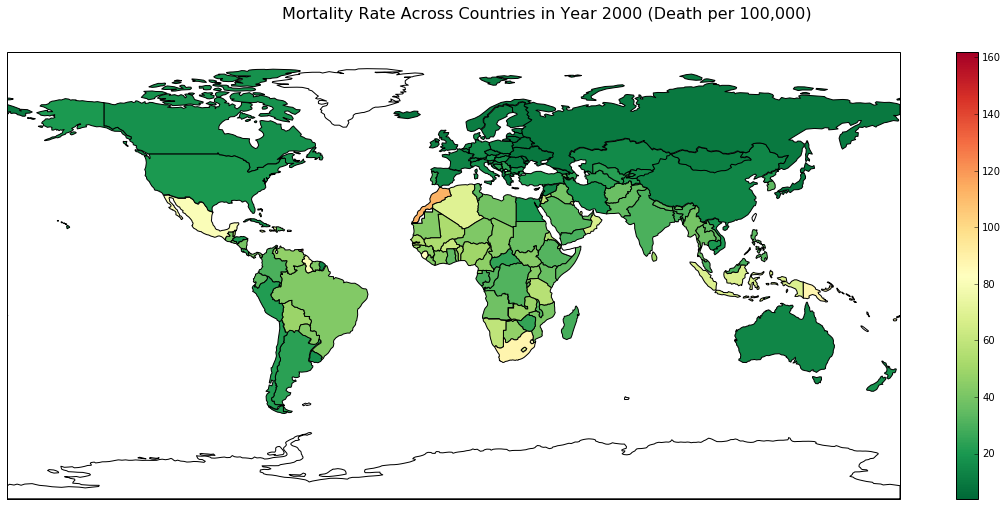

In [5]:
plot_map_disease(diabetes2000, "Mortality Rate Across Countries in Year 2000 (Death per 100,000)")

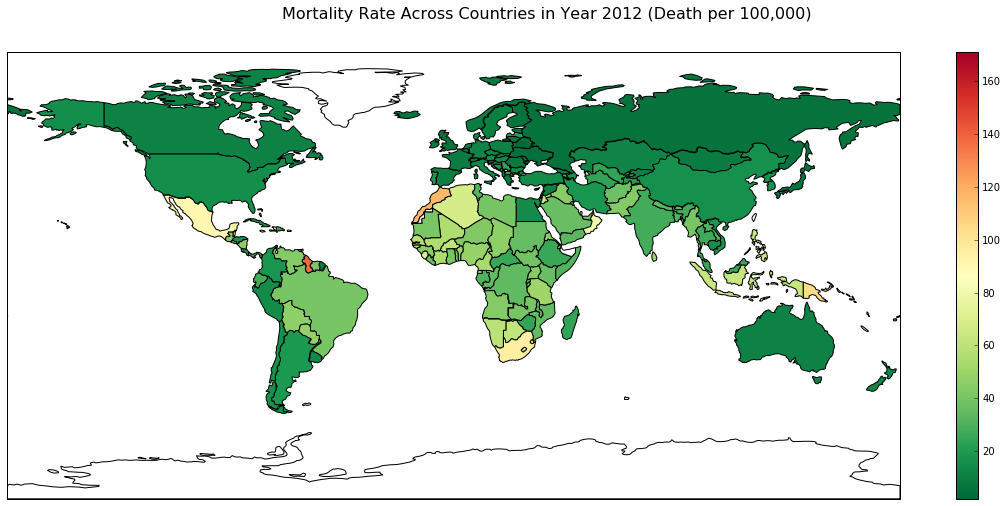

In [6]:
plot_map_disease(diabetes2012, "Mortality Rate Across Countries in Year 2012 (Death per 100,000)")

If we also then plot the change in diabetes rates from 2000 and 2012 on a world map, we actually see a surprisingly different trend:

/Applications/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


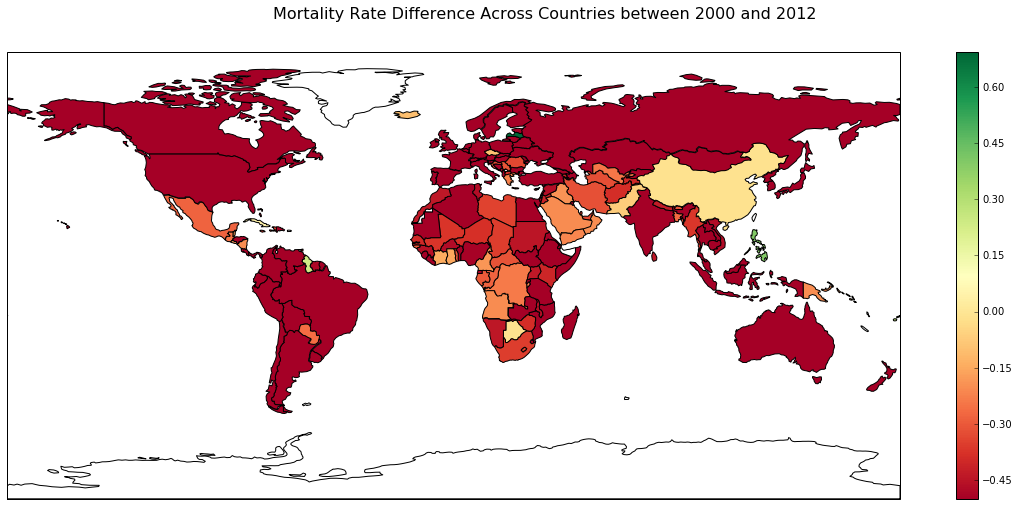

In [8]:
diabetes2000 = diabetes[diabetes['year'] == 2000]
diabetes2012 = diabetes[diabetes['year'] == 2012]
diff_list = []
for i in range(len(diabetes2000)):
    diff = (diabetes2012['both'].iloc[i] - diabetes2000['both'].iloc[i])/diabetes2012['both'].iloc[i]
    if diff < -0.5:
        diff = -0.5
        diff_list.append(diff)
    else:
        diff_list.append(diff)

sum(diff_list)
diabetes2000 = diabetes[diabetes['year'] == 2000]
diabetes2012 = diabetes[diabetes['year'] == 2012]
diabetes2012["both"] = diff_list
diabetes_diff = diabetes2012

plot_map_disease(diabetes_diff, "Mortality Rate Difference Across Countries between 2000 and 2012 ")

Here we see that although the average change in Diabetes rates from 2000 to 2012 is around 3% as calculated above, most countries actually experienced a **decrease in Diabetes** rates. Hence, the average increase is likely skewed by the high increase of a select few countries. This is good news. Looks like most countries have Diabetes under control as its rate is falling through the years.

However, some countries still have pretty high Diabetes rates (while others have pretty low Diabetes rates). Hence, we still have reason to dig further into the different diets of these two groups of countries. 

We'll come back to this again after we inspect the food data. That might need some cleaning.

## Inspect food data and fill in missing data

Our food data comes in 2 separate files, as "crops" and "livestocks". We first load the csv files and peek into the file and see if there are missing data that need first to be filled in before any further model investigation. During the data cleaning process, we will keep our two source files of food separate, consistent with their initial format. 

In [4]:
crops = pd.read_csv("datasets/crops.csv", delimiter=",")
livestock = pd.read_csv("datasets/livestock.csv", delimiter=",")

Noticing that in the givend at set, each food consumption is given in multiple different units, we will use g/capita/day as the uniformed unitis to use for all of our predictors. 

We first inspect the number of missing data for both the crop and livestock data. Specifically we inspect the three quantities: 
- Food supply (g/capita/day), 
- Protein supply (g/capita/day) and 
- Fat supply (g/capita/day). 

We calculate the percent of food data that has at least one year that is missing for that food item:

In [19]:
# g/capita/day for each food item across all years to predict disease incidence

cols = ["Y" + str(1961+i) for i in range(0, 52)]
cropMissingFood = 0
cropMissingProtein = 0
cropMissingFat = 0
livestockMissingFood = 0
livestockMissingProtein = 0
livestockMissingFat = 0

for ind, row in crops.iterrows():
    yearvalues = row[cols].tolist()
    if row['Element'] == 'Food supply quantity (g/capita/day)':
        if np.isnan(yearvalues).any():
            cropMissingFood += 1
    elif row['Element'] == 'Protein supply quantity (g/capita/day)':
        if np.isnan(yearvalues).any():
            cropMissingProtein += 1
    elif row['Element'] == 'Fat supply quantity (g/capita/day)':
        if np.isnan(yearvalues).any():
            cropMissingFat += 1
            
for ind, row in livestock.iterrows():
    yearvalues = row[cols].tolist()
    if row['Element'] == 'Food supply quantity (g/capita/day)':
        if np.isnan(yearvalues).any():
            livestockMissingFood += 1
    elif row['Element'] == 'Protein supply quantity (g/capita/day)':
        if np.isnan(yearvalues).any():
            livestockMissingProtein += 1
    elif row['Element'] == 'Fat supply quantity (g/capita/day)':
        if np.isnan(yearvalues).any():
            livestockMissingFat += 1

In [20]:
# Count number of missing rows

crops['Element'].unique()

print 'Percent of rows with missing crop food data: ', cropMissingFood*1.0 / crops[crops['Element'] == 'Food supply quantity (g/capita/day)'].shape[0]
print 'Percent of rows with missing crop protein data: ', cropMissingProtein*1.0 / crops[crops['Element'] == 'Protein supply quantity (g/capita/day)'].shape[0]
print 'Percent of rows with missing crop fat data: ', cropMissingFat*1.0 / crops[crops['Element'] == 'Fat supply quantity (g/capita/day)'].shape[0]
print 'Percent of rows with missing livestock food data: ', livestockMissingFood*1.0 / livestock[livestock['Element'] == 'Food supply quantity (g/capita/day)'].shape[0]
print 'Percent of rows with missing livestock protein data: ', livestockMissingProtein*1.0 / livestock[livestock['Element'] == 'Protein supply quantity (g/capita/day)'].shape[0]
print 'Percent of rows with missing livestock fat data: ', livestockMissingFat*1.0 / livestock[livestock['Element'] == 'Fat supply quantity (g/capita/day)'].shape[0]

Percent of rows with missing crop food data:  0.798223195814
Percent of rows with missing crop protein data:  0.798822588851
Percent of rows with missing crop fat data:  0.791639260396
Percent of rows with missing livestock food data:  0.801400846345
Percent of rows with missing livestock protein data:  0.798744769874
Percent of rows with missing livestock fat data:  0.79980037074


**Around 80% of food items in each country have at least one of the years' value missing from the years 1961 to 2012. **

### "2-nearest-neighbor" to fill in data

We definitely have to fill in missing values in this case. We could use linear regression, but it will be better for us to use the average of the two nearby years. Essentially, this is a variant of 2-nearest-neighbor. Here's how we do it: We keep going to the left until we pick a year that has a filled value (historic year). Then we keep going to the right until we pick a year that has a filled value (future year). We average the values from the historic year and the future year to fill in the current value. If we could not get a value from either the left or right side, we pick the one nearest from the direction that has filled values. If we cannot get a value from both sides, we fill in zero. 

In [21]:
# 2-nearest-neighbor filling in

cols = ["Y" + str(1961+i) for i in range(0, 52)]
cropMissingFood = 0
cropMissingProtein = 0
cropMissingFat = 0
livestockMissingFood = 0
livestockMissingProtein = 0
livestockMissingFat = 0

# Given missing index and all year's values, fill the value in with the
# average of the nearest left and right neighbors, or in other words, 
# average of the nearest historic and future year.
def filledValue(index, values):
    left = 0
    right = 0
    
    ind = index
    while ind > 0:
        ind -= 1
        if not np.isnan(values[ind]):
            left = values[ind]
            break
    
    ind = index
    while ind < len(values) - 1:
        ind += 1
        if not np.isnan(values[ind]):
            right = values[ind]
            break

    return (left + right)*1.0 / 2

# Fills in one row
def fillInRow(values, df, rowindex):
    for i in range(0, len(values)):
        if np.isnan(values[i]): # Missing so fill in value
            values[i] = filledValue(i, values)
    # After filling in all years' values, replace the row
    df.loc[rowindex:rowindex, cols] = values

In [22]:
# Fill in all crops
missingRowFilled = 0
for ind, row in crops.iterrows():
    if ind % 10000 == 0:
        print 'Done filling in row: ', ind
    yearvalues = row[cols].tolist()
    if (row['Element'] == 'Food supply quantity (g/capita/day)' 
    or row['Element'] == 'Protein supply quantity (g/capita/day)' 
    or row['Element'] == 'Fat supply quantity (g/capita/day)'):    
        if np.isnan(yearvalues).any():
            missingRowFilled += 1
            fillInRow(yearvalues, crops, ind)

Done filling in row:  0
Done filling in row:  10000
Done filling in row:  20000
Done filling in row:  30000
Done filling in row:  40000
Done filling in row:  50000
Done filling in row:  60000
Done filling in row:  70000
Done filling in row:  80000
Done filling in row:  90000


Now that we are done filling in the crop data, we check out how many rows have been filled up with our "2-nearest-neighbor":

In [23]:
missingCount = 0
for ind, row in crops.iterrows():
    yearvalues = row[cols].tolist()
    if (row['Element'] == 'Food supply quantity (g/capita/day)' 
        or row['Element'] == 'Protein supply quantity (g/capita/day)' 
        or row['Element'] == 'Fat supply quantity (g/capita/day)'):
        if np.isnan(yearvalues).any():
            missingCount += 1

In [24]:
print 'Number of missing crop rows now: ', missingCount
print 'Number of crop rows filled out: ', missingRowFilled

Number of missing crop rows now:  0
Number of crop rows filled out:  34941


Now that we are done filling in the crop data, we fill in the livestock data.

In [25]:
# Fill in all livestock
missingRowFilled = 0
for ind, row in livestock.iterrows():
    if ind % 10000 == 0:
        print 'Done filling in row: ', ind
    yearvalues = row[cols].tolist()
    if (row['Element'] == 'Food supply quantity (g/capita/day)' 
    or row['Element'] == 'Protein supply quantity (g/capita/day)' 
    or row['Element'] == 'Fat supply quantity (g/capita/day)'):    
        if np.isnan(yearvalues).any():
            fillInRow(yearvalues, livestock, ind)
            missingRowFilled += 1

Done filling in row:  0
Done filling in row:  10000
Done filling in row:  20000
Done filling in row:  30000
Done filling in row:  40000


Now that we are done filling in the livestock data, we check out how many rows have been filled up with our "2-nearest-neighbor":

In [26]:
missingCount = 0
for ind, row in livestock.iterrows():
    yearvalues = row[cols].tolist()
    if (row['Element'] == 'Food supply quantity (g/capita/day)' 
        or row['Element'] == 'Protein supply quantity (g/capita/day)' 
        or row['Element'] == 'Fat supply quantity (g/capita/day)'):
        if np.isnan(yearvalues).any():
            missingCount += 1

In [27]:
print 'Number of missing livestock rows now: ', missingCount
print 'Number of livestock rows filled out: ', missingRowFilled

Number of missing livestock rows now:  0
Number of livestock rows filled out:  16828


Now that we are done filling in all values of crop and livestock food items. We write out both data to file.

In [28]:
def getHeaders(filename):
    f = open(filename, 'rb')
    reader = csv.reader(f)
    headers = reader.next()
    return headers

cropHeaders = getHeaders("datasets/crops.csv")
livestockHeaders = getHeaders("datasets/livestock.csv")

with open("datasets/crops_filled-knn.csv", 'wb') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cropHeaders)
    for ind, row in crops.iterrows():
        writer.writerow(row.tolist())
        
with open("datasets/livestock_filled-knn.csv", 'wb') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(livestockHeaders)
    for ind, row in livestock.iterrows():
        writer.writerow(row.tolist())

### Linear regression to fill in data

Another way to fill in missing data is to use linear regression. We can do this by adding all filled values to 'train', and all missing values to 'test', train our linear regression model on 'train', then predict for 'test' and insert the row back. 

In [15]:
crops = pd.read_csv("datasets/crops.csv", delimiter=",")
livestock = pd.read_csv("datasets/livestock.csv", delimiter=",")

In [16]:
def fillInDataWithLinRegAndWriteToFile(filename, df, headers):
    cols = ["Y" + str(1961+i) for i in range(0, 52)]
    rows_filled = 0

    with open(filename, 'wb') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(headers)

        for ind, row in df.iterrows():
            
            if (row['Element'] == 'Food supply quantity (g/capita/day)' 
                or row['Element'] == 'Protein supply quantity (g/capita/day)' 
                or row['Element'] == 'Fat supply quantity (g/capita/day)'):
                
                yearvalues = row[cols].tolist()

                # If true, there is at least one NaN value
                if np.isnan(yearvalues).any():
                    xtest = [] # Years with missing values
                    xtrain = [] # Years since 1961
                    ytrain = [] # Value at that year
                    yfull = [] # Full y, with missing values being replaced initially by -1

                    # Find the year with the NaN value
                    for i in range(0, len(yearvalues)):
                        if not np.isnan(yearvalues[i]):
                            xtrain.append(i)
                            ytrain.append(yearvalues[i])
                            yfull.append(yearvalues[i])
                        else:
                            xtest.append(i)
                            yfull.append(-1.0)
                    xtrain = [[xi] for xi in xtrain]
                    xtest = [[xi] for xi in xtest]

                    # Predict for all the missing years
                    linreg = LinearRegression()
                    linreg.fit(xtrain, ytrain)
                    yhats = linreg.predict(xtest)

                    # Fill up yfull with yhats, then insert back into frame
                    yfull = np.asarray(yfull)
                    for i in range(0, len(xtest)):
                        yfull[xtest[i]] = yhats[i]
                    row[cols] = yfull
                    rows_filled += 1
            writer.writerow(row.tolist())
    return rows_filled

In [29]:
# Fill in data using linear regression and write to file
l_rows_filled = fillInDataWithLinRegAndWriteToFile('datasets/livestock_filled-linreg.csv', livestock, getHeaders('datasets/livestock.csv'))
c_rows_filled = fillInDataWithLinRegAndWriteToFile('datasets/crops_filled-linreg.csv', crops, getHeaders('datasets/crops.csv'))

Now let's check if our linear regression imputation worked and how many rows were filled out:

In [30]:
print 'Number of crop rows filled out: ', c_rows_filled

Number of crop rows filled out:  0


In [31]:
print 'Number of livestock rows filled out: ', l_rows_filled

Number of livestock rows filled out:  0


### Choosing the better imputation algorithm to fill in

Which method of filling in is better? We have reason to believe that linear regression would do better if most of the missing values are at the extreme corners, i.e years 2012 and 1961. Let's see how many rows have missing values at those corners:

In [32]:
crops_new = pd.read_csv("datasets/crops.csv", delimiter=",")
livestock_new = pd.read_csv("datasets/livestock.csv", delimiter=",")

In [33]:
falsematrixOfNonCorners = np.isnan(crops_new[cols[1:-1]])
countOfNanThatAreNotAtCorners = 0
for i in range(crops_new.shape[0]):
    if sum(sum(falsematrixOfNonCorners.loc[i:i].as_matrix())) > 0:
        countOfNanThatAreNotAtCorners += 1
countOfNanAtCorners = sum(np.isnan(crops_new['Y2012'])) + sum(np.isnan(crops_new['Y1961']))

print 'Number of rows in crop data that have at least one missing value that are not at corners: ', countOfNanThatAreNotAtCorners
print 'Number of rows in crop data that have at least one missing value at corners: ', countOfNanAtCorners

falsematrixOfNonCorners = np.isnan(livestock_new[cols[1:-1]])
countOfNanThatAreNotAtCorners = 0
for i in range(livestock_new.shape[0]):
    if sum(sum(falsematrixOfNonCorners.loc[i:i].as_matrix())) > 0:
        countOfNanThatAreNotAtCorners += 1
countOfNanAtCorners = sum(np.isnan(livestock_new['Y2012'])) + sum(np.isnan(livestock_new['Y1961']))

print 'Number of rows in livestock data that have at least one missing value that are not at corners: ', countOfNanThatAreNotAtCorners
print 'Number of rows in livestock data that have at least one missing value at corners: ', countOfNanAtCorners

Number of rows in crop data that have at least one missing value that are not at corners:  14052
Number of rows in crop data that have at least one missing value at corners:  85502
Number of rows in livestock data that have at least one missing value that are not at corners:  6682
Number of rows in livestock data that have at least one missing value at corners:  38820


As most of the missing data are from corners, we choose **linear regression** as our algorithm to fill in missing data. From here on, we will perform our analyses on the files **crops_filled-linreg.csv** and **livestock_filled-linreg.csv**.

## Back to Disease: Which countries have the lowest or highest Diabetes rates?

Now that we have filled in the missing data in food, we can start to explore what countries eat. We first look at which countries have the lowest and highest Diabetes rates respectively:

In [39]:
crops = pd.read_csv("datasets/crops_filled-linreg.csv", delimiter=",")
livestock = pd.read_csv("datasets/livestock_filled-linreg.csv", delimiter=",")
disease_data = pd.read_csv("datasets/diabetes.csv", delimiter=",", skiprows=2)

In [45]:
# Remove repeated milk - excluding butter

def removeRepeatFood(food):
# Get all countries, for each country get query, and drop one of the two rows
    countries = livestock.Country.unique()
    for country in countries:
        item = livestock[(livestock.Country == country) & (livestock.Item == food) & (livestock.Element == 'Food supply quantity (g/capita/day)')]
        for i in range(1, len(item)): # Delete all repeats
            livestock.drop([item.index[i]], inplace=True)
            
    
removeRepeatFood('Milk - Excluding Butter')

In [40]:
# Grab the 6 healthiest countries
healthiest_countries = diabetes_data[diabetes_data.Year == 2012].sort_values(' Both sexes')[:7]
# We remove Singapore and use UK because Singapore is not in food data
healthiest_countries = pd.concat((healthiest_countries[:3], healthiest_countries[4:]), axis=0)
# We rename United Kingdom of Great Britain and Northern Ireland to just United Kingdom
healthiest_countries.iloc[-1,0] = 'United Kingdom'
healthiest_countries

,Country,Year,Both sexes,Female,Male
26,Belarus,2012,1.9,1.7,2.0
320,Ukraine,2012,3.2,3.1,3.2
274,Slovenia,2012,3.6,3.1,4.2
160,Japan,2012,3.9,2.5,5.4
112,Finland,2012,4.2,3.0,5.6
324,United Kingdom,2012,4.2,3.6,5.0


In [41]:
# Grab the 6 most unhealthy countries
unhealthiest_countries = diabetes_data[diabetes_data.Year == 2012].sort_values(' Both sexes')[-10:]
# We remove Papua New Guinea, Mauritius and use South Africa and Mexico because the former is not in food data
unhealthiest_countries = pd.concat((unhealthiest_countries[:1], unhealthiest_countries[2:3], unhealthiest_countries[5:-1]), axis=0)
unhealthiest_countries

,Country,Year,Both sexes,Female,Male
204,Mexico,2012,90.5,86.0,95.8
280,South Africa,2012,94.3,91.0,98.5
210,Morocco,2012,115.7,122.0,106.2
310,Trinidad and Tobago,2012,127.3,105.1,155.0
134,Guyana,2012,138.2,142.1,129.5
110,Fiji,2012,151.7,134.7,170.1


**The 6 most healthy countries are: Belarus, Ukraine, Slovenia, Japan, Finland and United Kingdom. **

**The 6 most unhealthy countries are: Mexico, South Africa, Morocco, Trinidad and Tobago, Guyana and Fiji.**

Let's next examine what these countries are eating, i.e. what their diet consists of. Here we inspect the top 5 crops and top 5 livestock each country eats in 2000. We plot pie charts to see the **relative size** of each food's consumption among the top 5 foods.

In [46]:
# Functions to plot the pie charts for the top 5 crops and livestock for each of the 12 countries chosen

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def plot_pie(data, title, label, ax):
    color = ['peachpuff','gold','greenyellow','limegreen','forestgreen','blue','deepskyblue','dodgerblue','plum', 'darkviolet']
    ax.pie(data, colors=color, labels = label, autopct=make_autopct(data), startangle=90)
    ax.set_title(title)
    return ax

def plot_pie_charts(dict_countries, year, k):
    fig, axes = plt.subplots(3, 2, figsize=(20, 30))
    i=0
    for country in dict_countries.keys():
        eg = dict_countries[country]
        eg = eg.sort_values(by = 'Y' + str(year), ascending=[False])
        # Get top k foods
        eg_sub = eg.iloc[:k,:]
        plot_pie(eg_sub['Y' + str(year)], country, eg_sub['Item'], fig.axes[i])
        i+=1

First let's do a **livestock comparison**. Let's see if there is any difference in the top livestock that healthy and unhealthy countries eat:

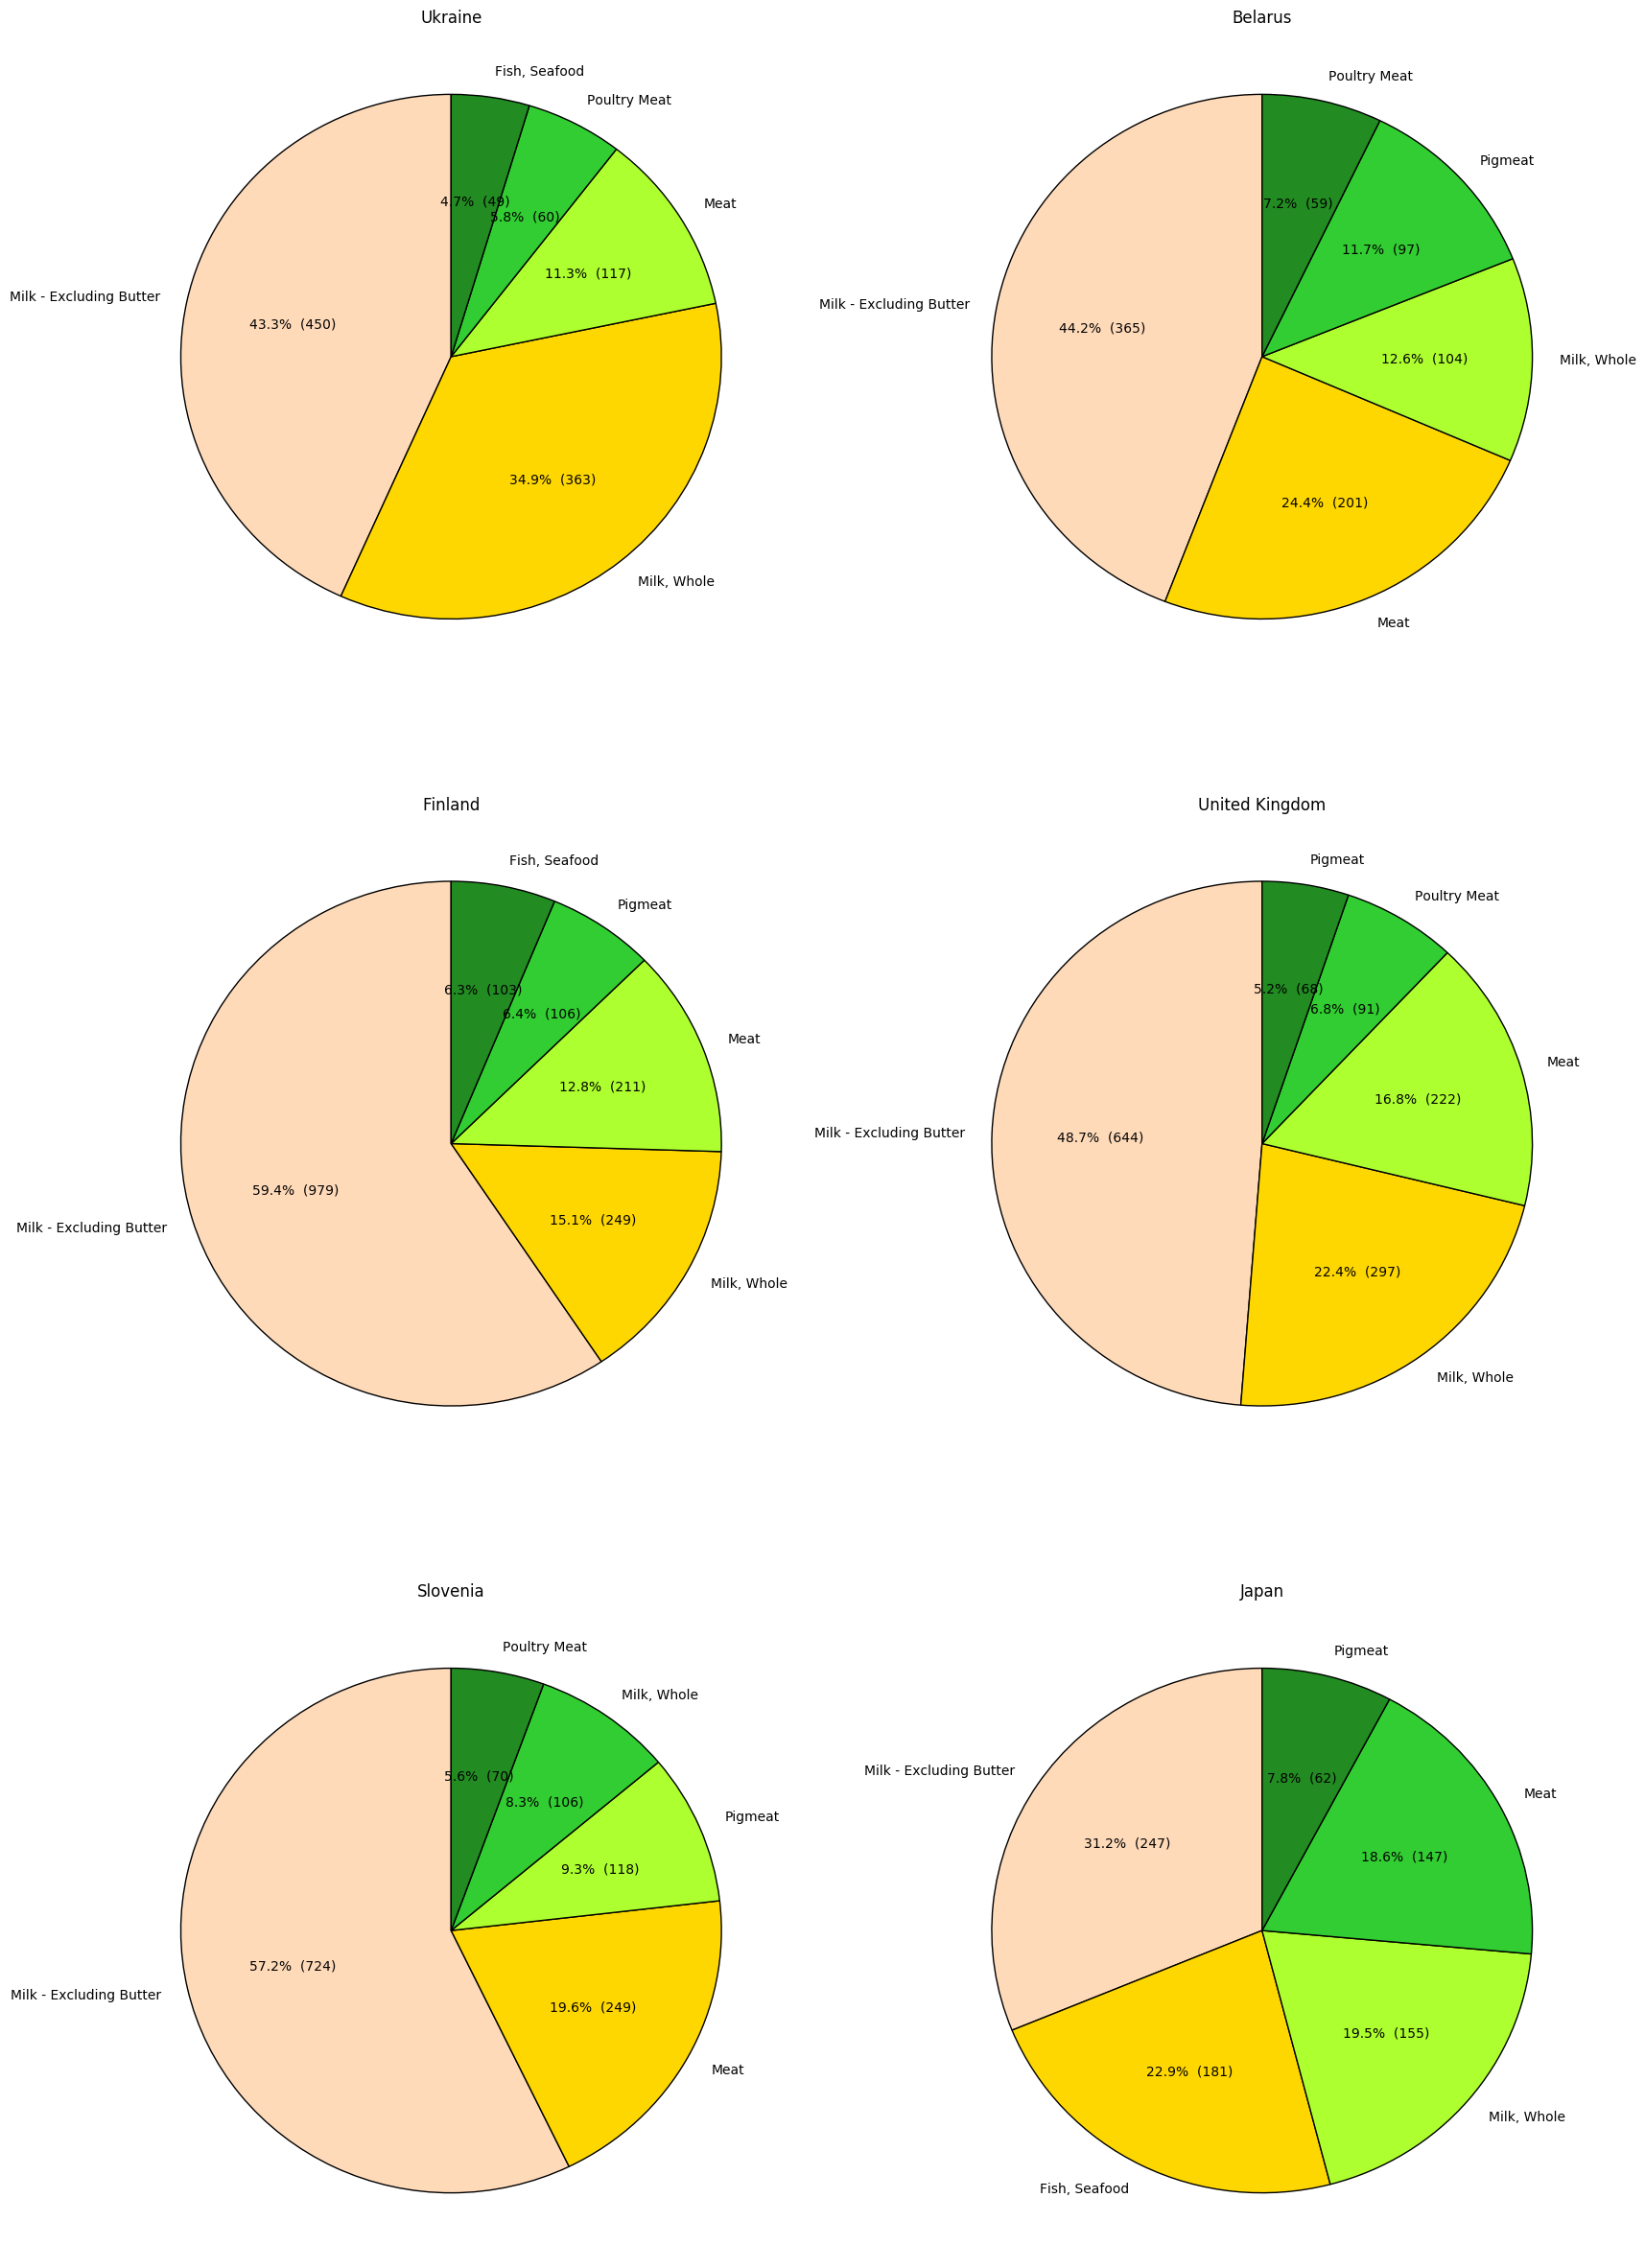

In [47]:
# Plot the livestock for the healthiest countries
dict_healthiest_countries = {}
for x in healthiest_countries['Country']:
    dict_healthiest_countries[x] = livestock[(livestock.Country == x) & (livestock.Element == 'Food supply quantity (g/capita/day)')]
plot_pie_charts(dict_healthiest_countries, 2012, 5)

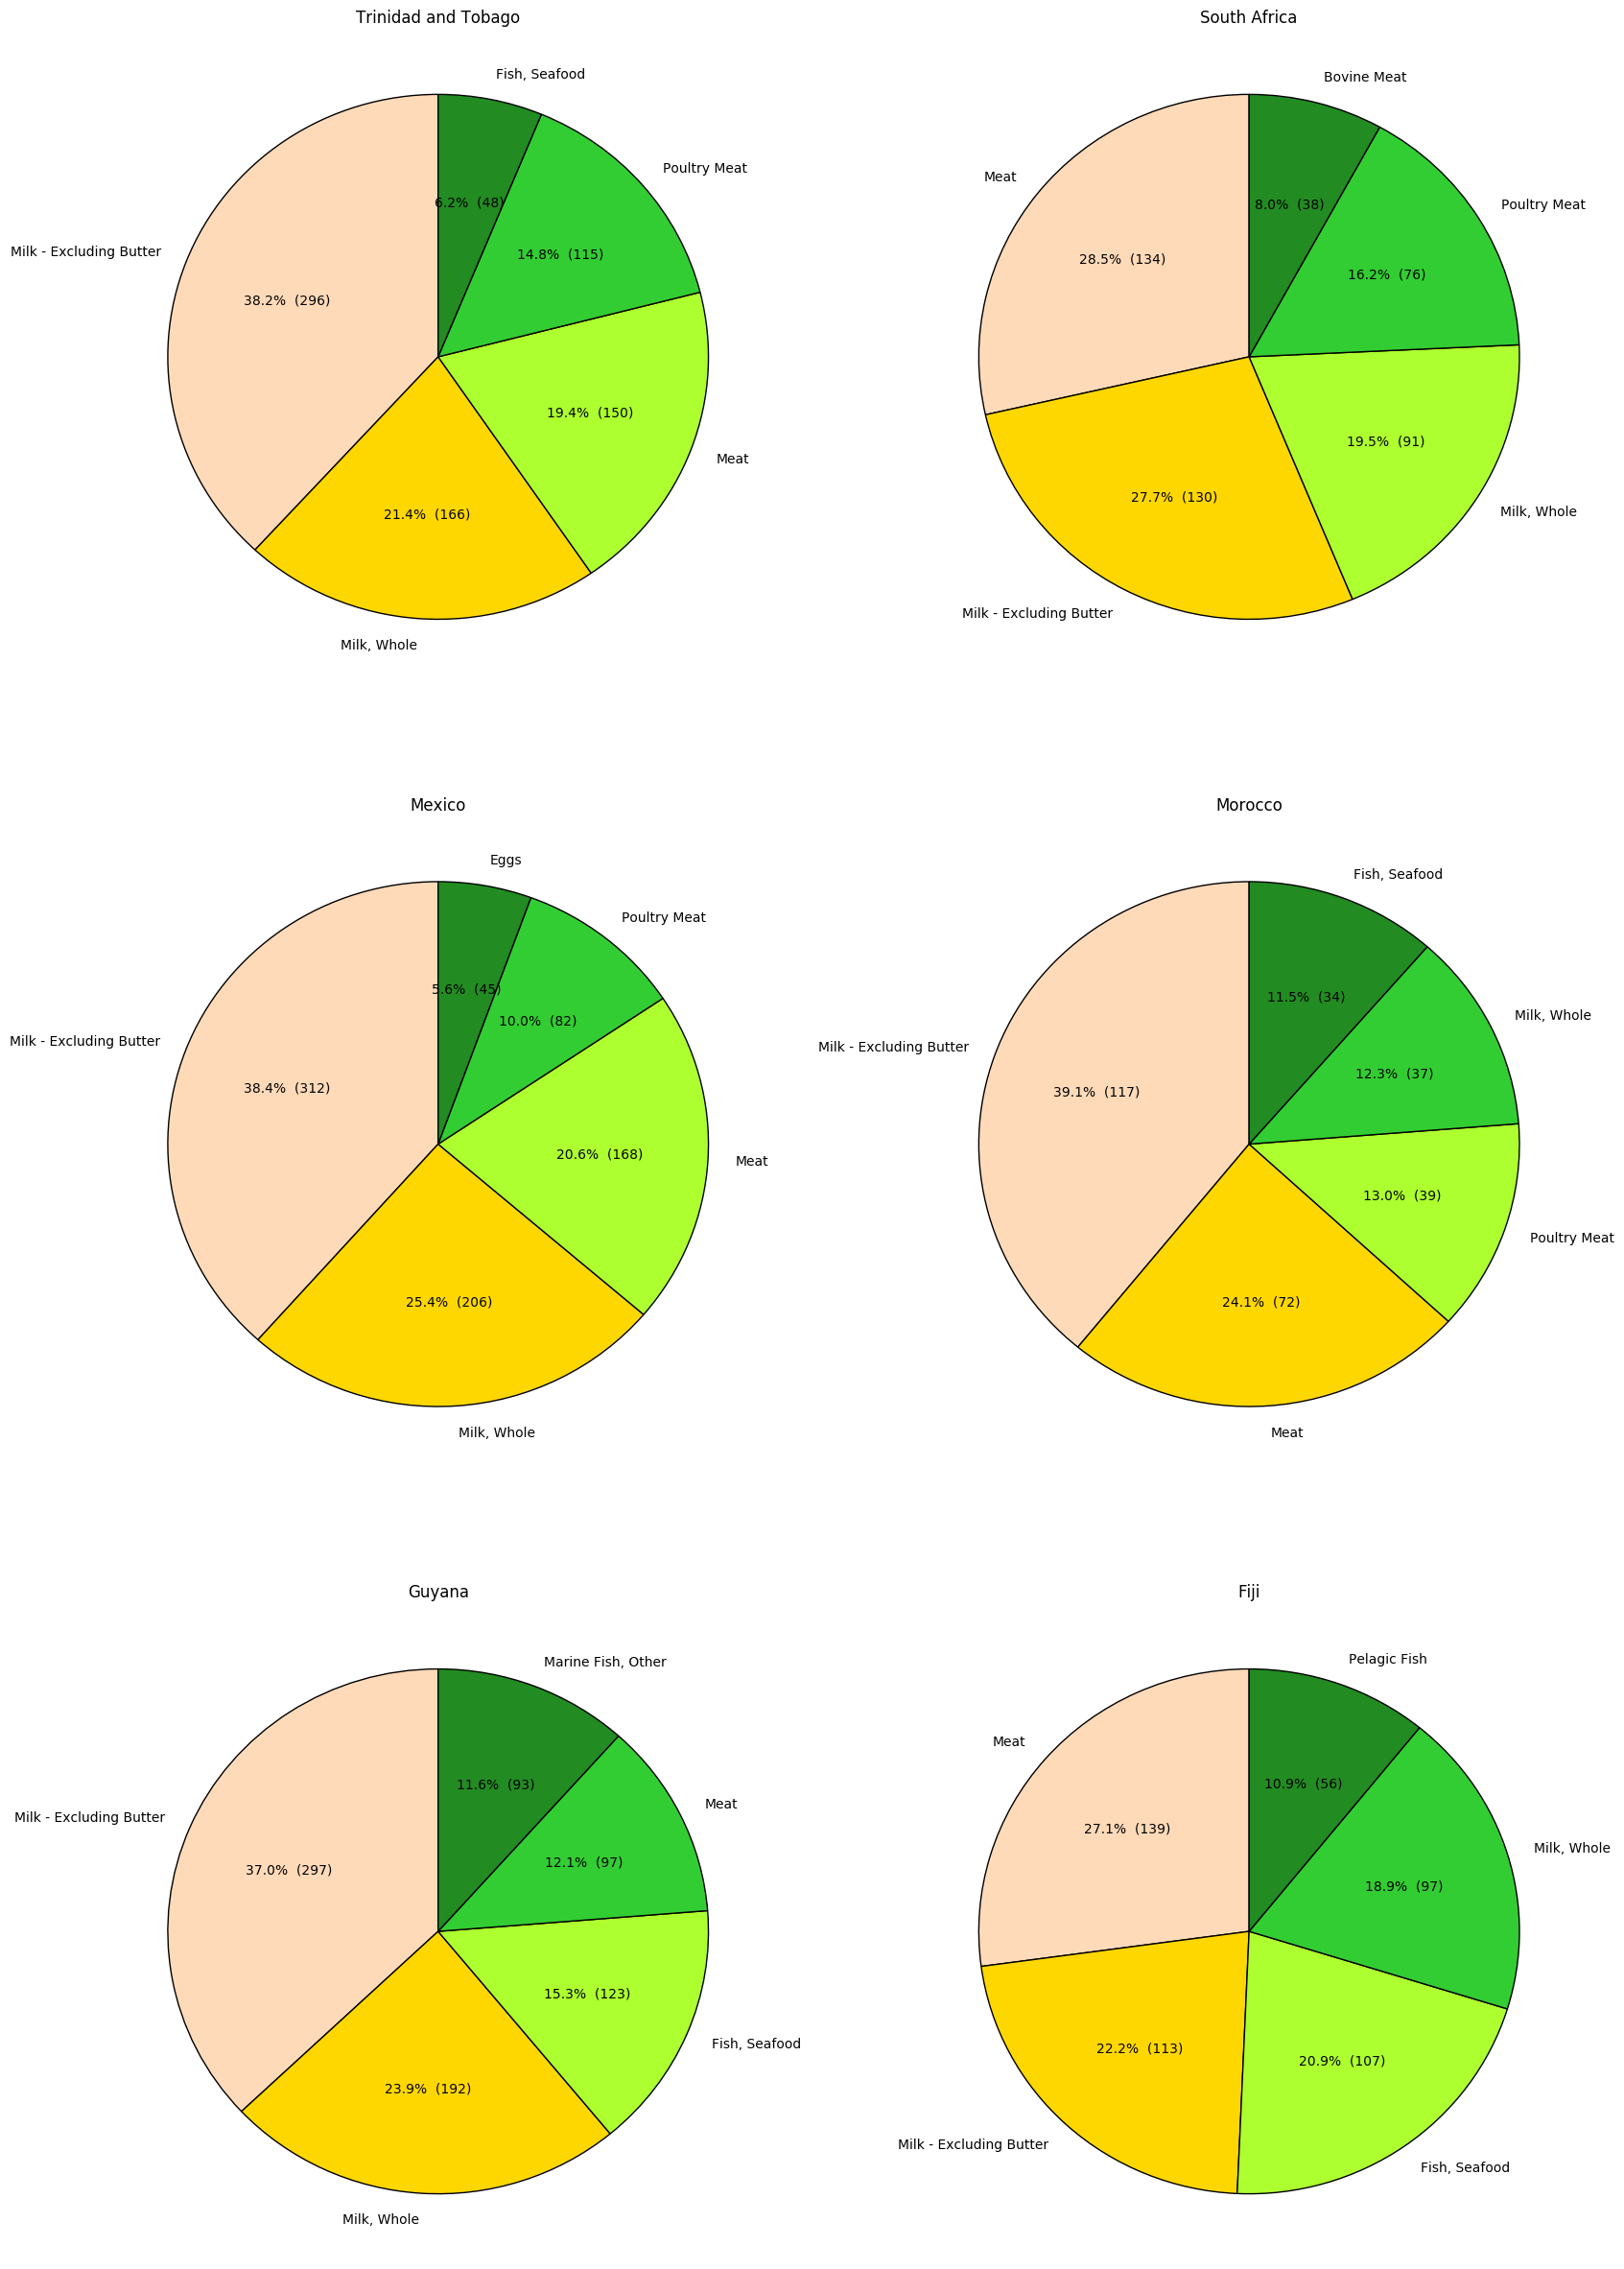

In [49]:
# Plot the livestock for the unhealthiest countries
dict_unhealthiest_countries = {}
for x in unhealthiest_countries['Country']:
    dict_unhealthiest_countries[x] = livestock[(livestock.Country == x) & (livestock.Element == 'Food supply quantity (g/capita/day)')]
plot_pie_charts(dict_unhealthiest_countries, 2012, 5)

**Comparing the livestock between the most and least healthy countries, we do not see a significant difference.** It seems these countries have similar diets. At first glance, it seems as though healthy countries eat more fish, but there are also unhealthy countries such as Fiji and Guyana that eats a lot of fish.

Now we do a comparison on the **top crops that are consumed:**

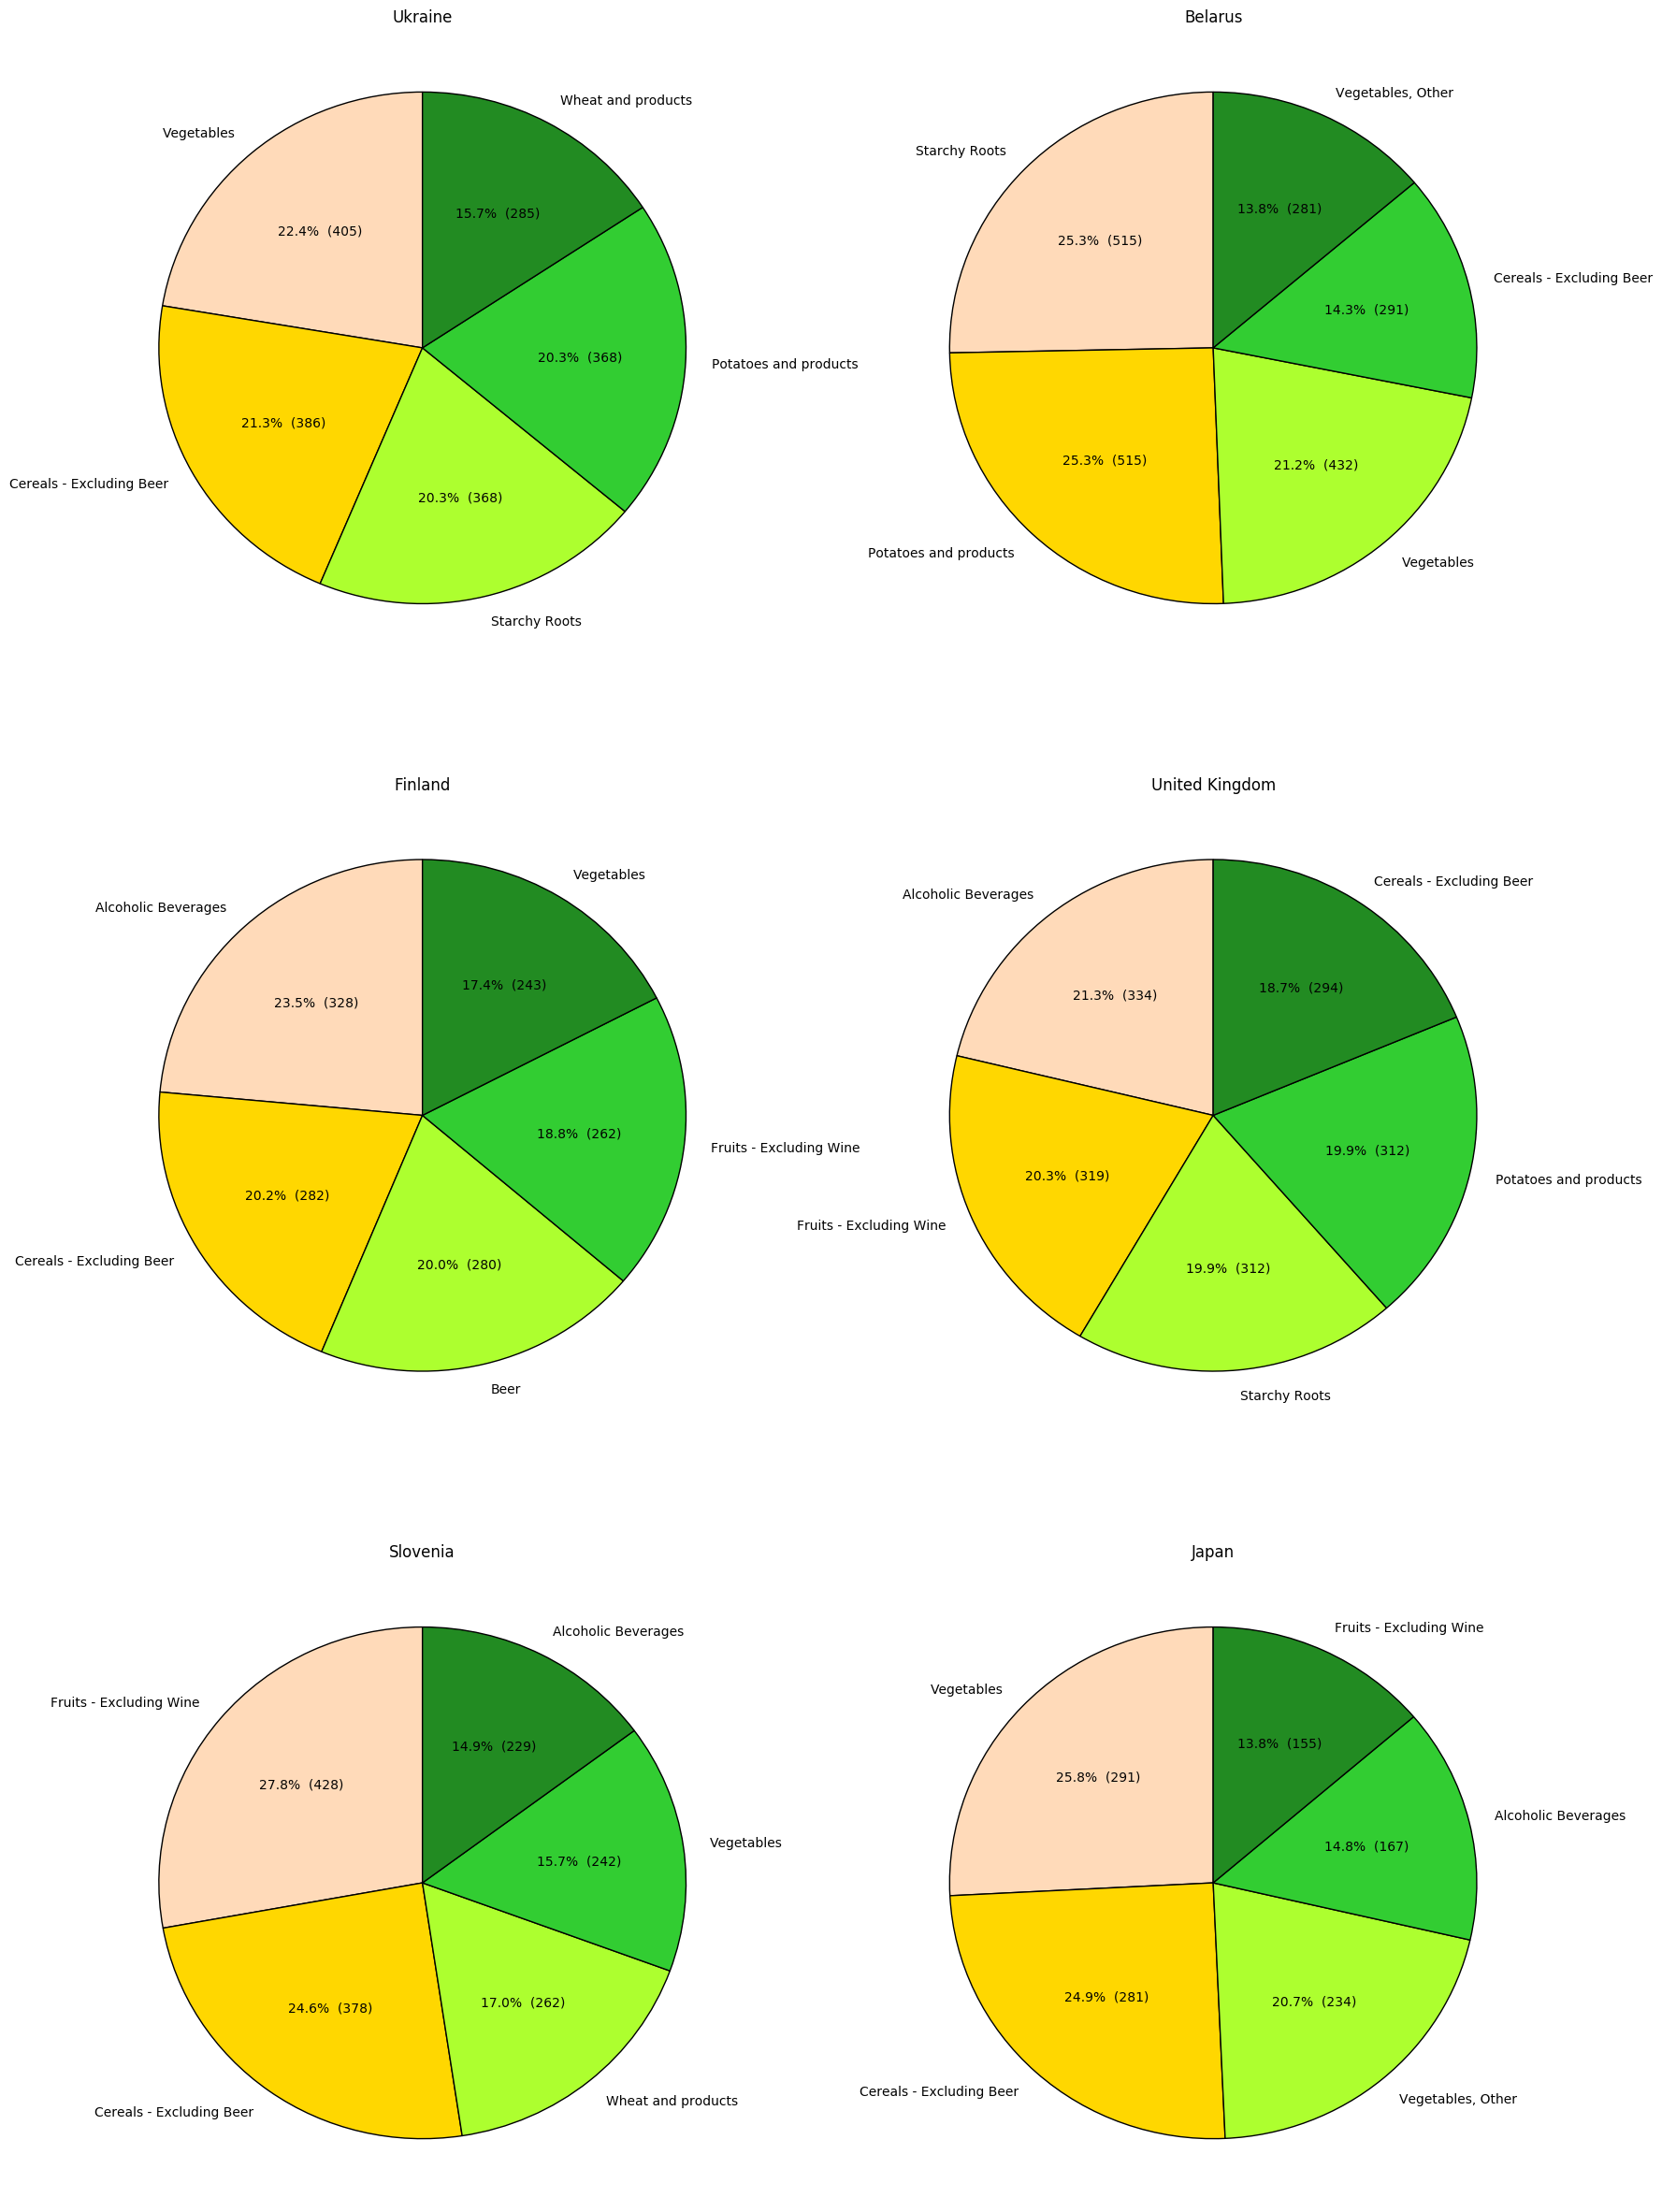

In [50]:
# Plot the crops for the healthiest countries
dict_healthiest_countries = {}
for x in healthiest_countries['Country']:
    dict_healthiest_countries[x] = crops[(crops.Country == x) & (crops.Element == 'Food supply quantity (g/capita/day)')]
plot_pie_charts(dict_healthiest_countries, 2012, 5)

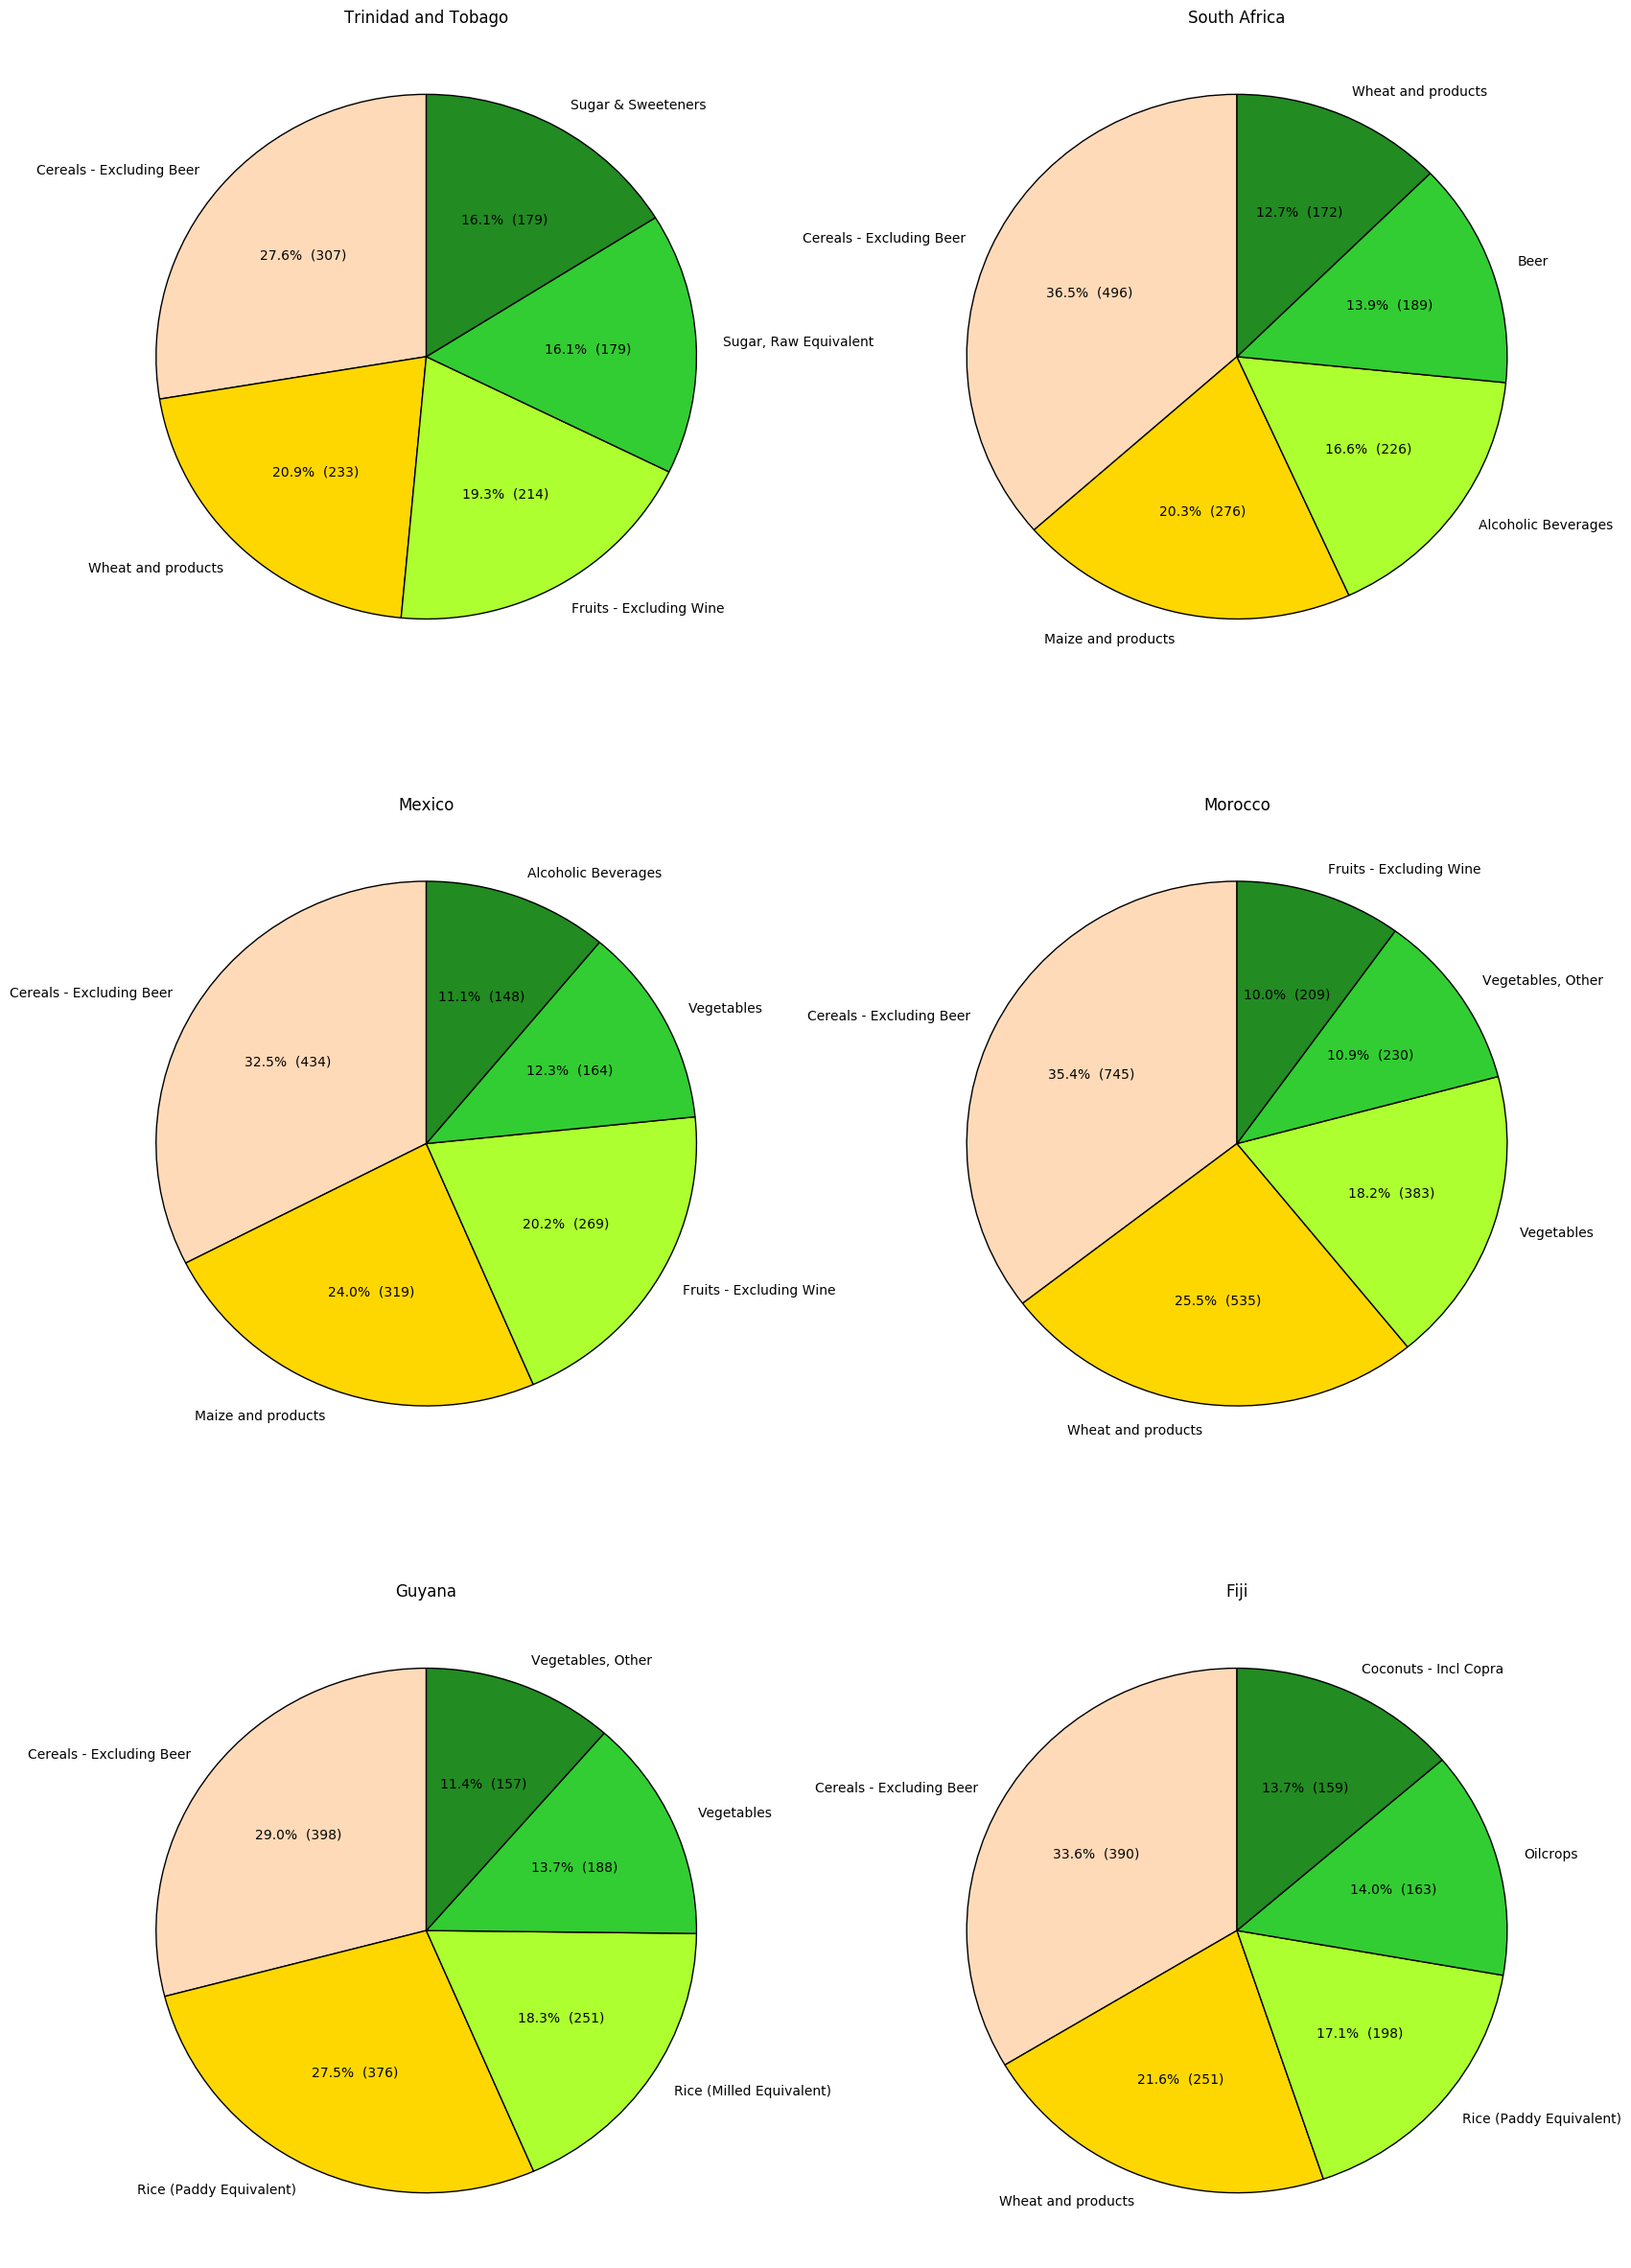

In [51]:
# Plot the crops for the unhealthiest countries
dict_unhealthiest_countries = {}
for x in unhealthiest_countries['Country']:
    dict_unhealthiest_countries[x] = crops[(crops.Country == x) & (crops.Element == 'Food supply quantity (g/capita/day)')]
plot_pie_charts(dict_unhealthiest_countries, 2012, 5)

**Once again from the crops comparison, we don't see a significant difference.** Initially it might seem that the healthy countries such as Finland and United Kingdom drank more Alcohol, but there are also unhealthy countries such as South Africa that consume a lot of Alcohol. 

For our poster and website, we will generate word clouds for the food items that healthy and unhealthy countries consume.

Now that we have explored what healthy and unhealthy countries eat and realized their diets are not too different - we are somewhat stuck. Can food really predict diabetes? We decide to dig deeper and use prediction tools we learnt in AC209a to see if specific food items could predict diabetes rates.

## Craft prediction models

To start exploring models for prediction, we read in the filled in data as filled by linear regression in the previous section. We define our own $R^2$ function for future use in evaluating the model performance. 

In [60]:
# Loss function: R^2
def r2(y_test, y_pred):
    RSS = np.sum((y_test-y_pred)**2)
    TSS = np.sum((y_test-np.mean(y_pred))**2)
    R2 = 1.0-RSS/TSS
    return R2

### Taking mean consumption for each item across n years before the disease year as the predictor

From the food data, we originally have more than 100 types of crops and livestocks in total, from year 1961 to 2013 for 154 countries in total. If we were to include all of the food consumptions(using g/capita/day as the unified unit) from all years as the predictors, we will essentially have thousands of predictors in total. However, since we only have approximately 150 countries as observations, we may be facing a very serious high dimensional problem, with the number of predictors much more than the number of observations. 

As a result, we would instead take the mean consumption across a user defined year before the disease data year. We will tune the parameter for how many years to use to calculate the mean consumption for each food for each country, but to start with, we will use 10 years. With this choice, it allows us to have a smooth out representation of the average food consumption in the years most close to the disease data year, but also with 10 years, we are essentially not using overlapping data for year 2000 and 2012. That is, we use the average from 1991 to 2000 of food consumption for the disease rate in 2000, and use the avergae from 2002 to 2012 of food consumption for disease rate in 2012. 

It might potentially be a problem if we make the years included in the mean too large. More specifically, if we pick 35, then we are using the average of 1966 to 2000 food for disease 2000, and year 1978 to 2012 for disease 2012. Around 20 years included in the average food for these 2 years of disease rate are the same, and it makes little sense to have the predictors to be highly correlated. We will keep this issue in mind when we tune the parameter of how many years to use later.



The function written below takes in the parameter of number of years included in calculating food average, the disease data, disease year to look at, and the choice of gender to look at disease rate. We set the default disease year to be 2012, and the default disease gender to be "both", but notice that based on the data we have, we can change the year to be either 2000 or 2012, and the gender selection to be "both", "male", or "female". 

The returned value of the function below if of the form of combine x and y. More specifically, we have 122 columns of predictors, each representing a kind of food, and values being the average across number of year included before the disease year. The last column represents the response variable - the disease rate of the selected year. Each row in the return dataframe is a country, and we have in total 154 of them that both appeared in food data and the disease data. 

In [151]:
def getXY(num_years_included,disease, disease_year=2012, disease_gender="Both sexes"):    
    # Grab the appropriate food metrics
    crops_ = crops[(crops["Unit"] == "g/capita/day") & (crops["Element"] == "Food supply quantity (g/capita/day)")]
    livestock_ = livestock[(livestock["Unit"] == "g/capita/day") & (livestock["Element"] == "Food supply quantity (g/capita/day)")]

    # Years of food data needed before disease year
    years = ["Y" + str(disease_year - i) for i in range(num_years_included,-1,-1)]

    # Finding mean consumption across the years
    crops_["mean_consumption"] = np.mean(crops_[years],axis = 1)
    livestock_["mean_consumption"] = np.mean(livestock_[years],axis = 1)

    # Columns needed for prediction model
    cols = ["Country", "Item", "mean_consumption"]

    crops_ = crops_[cols]
    livestock_ = livestock_[cols]

    # Flatten data
    crops_pivot = crops_.pivot_table(["mean_consumption"], ['Country'], 'Item')
    livestock_pivot = livestock_.pivot_table(["mean_consumption"], ['Country'], 'Item')

    # Combine crops and livestock
    food = pd.concat([crops_pivot, livestock_pivot], axis=1)

    # Only use the countries that are in both food and response
    disease_countries = disease.iloc[:,0].as_matrix().astype(str) # This has 'nan' and 'Country' but it doesn't matter
    food_countries = food.index.tolist()
    common_countries = np.asarray(list(set(disease_countries).intersection(food_countries)))

    # Form the full xy
    x = food.loc[common_countries].sort_index()
    y = disease[(disease.Year == disease_year) & (disease.Country.isin(common_countries))][['Country', " " + disease_gender, ]].sort_index()

    # Precompute the means of each column, and fill in 
    means = np.mean(x)
    rowcount = 0
    for r in range(x.shape[0]):
        rowcount += 1
        for c in range(len(means)):
            # if nan, replace with mean
            '''
            Note: Countries that do not have a certain food item will be filled in with 
            the mean of that food item and not 0. This is because we do not want our results to be skewed too much 
            by 0s. Besides, after testing with 0s, we actually realize our results and R2 do not change that much.
            '''
            val = x.iloc[r,c]
            if np.isnan(val):
                x.iloc[r,c] = means[c]
            # if negative value, replace with 0
            if val < 0:
                x.iloc[r,c] = 0.0

    # Manually add y, because for some reason just appending the column results in column of NaNs
    xy = x 
    xy['Disease'] = 0.0
    for i in range(y.shape[0]):
        c = y.iloc[i,0]
        r = y.iloc[i,1]
        xy.loc[c]['Disease'] = r
    return xy

In [162]:
xy_diabetes_2012_all = getXY(10, disease=disease_data)
xy_diabetes_2000_all = getXY(10, disease=disease_data, disease_year=2000)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


To check that we have the desired data struncture, we print out the head of the returned dataframes from the getXY function. It shows below that we have the first couple columns being mean consumption as predictors, and the last columns being the response disease rate. 

In [163]:
# Clean out whole columns that are NaN
xy_diabetes_2012_all = xy_diabetes_2012_all.dropna(axis=1, how='all')
xy_diabetes_2000_all = xy_diabetes_2000_all.dropna(axis=1, how='all')

In [157]:
xy_diabetes_2000_all.head(5)

mean_consumption                                 \
Item        Alcoholic Beverages Apples and products    Bananas   
Country                                                          
Afghanistan            0.004516            3.360000   0.508387   
Albania               27.984194           15.529032   2.162903   
Algeria                7.864194            4.120323   0.708387   
Angola                48.741935            0.428065  69.893226   
Argentina            235.778065           39.232581  30.295484   

                                                                            \
Item        Barley and products      Beans       Beer Beverages, Alcoholic   
Country                                                                      
Afghanistan           36.220323   7.181520   0.001935             0.002258   
Albania                1.525806  11.158065  18.445484             3.180323   
Algeria               51.227742   3.480000   7.729032             0.105161   
Angola                 0.006452  20.547097  23.680000             1.839032   
Argentina              0.010000   0.777742  52.826129            10.575161   

                                                       \
Item        Beverages, Fermented Cassava and products   
Country                                                 
Afghanistan            20.511954            91.142403   
Albania                 0.028710             0.002258   
Algeria                 0.000323             0.002903   
Angola                 14.405161           478.217742   
Argentina               0.012903             8.775484   

                                       ...                                \
Item        Cereals - Excluding Beer   ...   Milk, Whole Molluscs, Other   
Country                                ...                                 
Afghanistan               585.182258   ...     90.704194        1.694060   
Albania                   571.890323   ...    301.602581        0.431935   
Algeria                   515.214839   ...    160.024516        0.000968   
Angola                    180.053226   ...     45.911290        0.000323   
Argentina                 338.679355   ...    254.878710        0.764194   

                                                                       \
Item        Mutton & Goat Meat     Offals Offals, Edible Pelagic Fish   
Country                                                                 
Afghanistan          26.954516   9.084194       9.084194    12.168142   
Albania              12.212581   6.860000       6.856774     1.166452   
Algeria              12.827097   3.089032       3.089032     6.745161   
Angola                1.442258   3.519677       3.519677    25.507419   
Argentina             9.145806  19.836129      19.840000     2.777097   

                                              Disease  
Item           Pigmeat Poultry Meat      Whey          
Country                                                
Afghanistan  28.501207     2.501935  1.924622    34.0  
Albania       9.396129     8.413548  1.924622     8.3  
Algeria       0.014839    14.206129  0.021613    67.2  
Angola        7.013226     4.616452  1.924622    35.0  
Argentina    20.768387    40.121613  0.750323    19.9  

[5 rows x 123 columns]

Now consider training and testing some of the potential models available for predicting disease rate from the amount of food consumption. Since each country may have different behaviors, and it then makes little sense to split the data on one year into a fraction of training and testing set, we will perform the training on one year of data and testing on another year. That is, we use the entire set of food and disease rate from year 2000 as training, and the entire set from year 2012 as the testing set. 

As mentioned above, the 122 columns of mean food consumption across the year will be the predictors, and the number of death per 100,000 from Diabetes will be the response. 

In [164]:
# Split into train and test
x_train = xy_diabetes_2000_all.iloc[:,:-1]
x_test = xy_diabetes_2012_all.iloc[:,:-1]
# Standardize x
x_train = preprocessing.scale(x_train)
x_test = preprocessing.scale(x_test)
y_train = xy_diabetes_2000_all.iloc[:,-1]
y_test = xy_diabetes_2012_all.iloc[:,-1]

#### Baseline Models

To kick off the model fitting procedure, we begin with two simple baseline models. 

- Null model: disease incidence in a country is the same as the global average
- Linear regression: predict health outcomes with all features

We report/print the corresponding $R^2$ from this model after each time we fit the model.

In [141]:
# Baseline model 1: Disease incidence in each country is equal the global average (Null model)

# Find the global average for all countries
global_average = np.mean(y_test)
y_pred = np.asarray([global_average]*y_test.shape[0])

# R2
print 'R squared of null baseline model: ', r2(y_test, y_pred)

R squared of null baseline model:  0.0


#### Analysis for Baseline Model 1 - Null Model
As expect for the null model, if we make all prediction equal to the global average, it is essentially the horizontal line passing through the mean value. This will give us a $R^2=0$ based on the definition of $R^2$. 

Any further model that is better than a horizontal line will have a positive $R^2$ and anything worse will then have negative $R^2$.  

The second baseline model is thus the linear model with all food items' mean consumption  as predictors without any transformation or regularization. 

In [137]:
# Bsseline model 2: Apply a non-regularized linear regression
linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)
print('Linear Regression\n====================')
print 'R squared of linear regression:', linreg.score(x_test, y_test)
print('')

Linear Regression
R squared of linear regression: -0.250269268077



#### Analysis for Baseline Model 2 - Linear Model

From the output above, we see that the simple linear model has a negative $R^2$. This implies that the linear model did a worse job compared to the null model. It could potentially be possible that when there are way too many food items(comparable number of 123 to the number of observations 154). Moreover, the predictors themselves may be correlated and yielding colinearity problem. For example, we do see multiple items related to meat/milk but only of a slightly different subtype. In this case, we might have too many terms and we would expect some methods with regularization or dimension reduction would be a better choice. 

Motivated by the poor score and our intuition behind, we will continue our exploration of fancier models:

- Ridge
- LASSO
- PCA
- Multivariate Adaptive Regression Spline (AC209a required additional method, will justify later)

#### Fancier Models

We try Ridge regression on the disease rate against food data above. Ridge will include regularization terms that penalize for a too large coefficient for too many terms even though it will not make the coefficient zero. 

In [132]:
# Ridge
ridge = Ridge()
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_train)
print('Ridge Regression\n====================')
print 'R squared of ridge regression:', ridge.score(x_test, y_test)
print('')


Ridge Regression
R squared of ridge regression: 0.513232645997



#### Analysis of Ridge
Ridge regression is essentially a linear model with added regularization term in the loss function. We have significantly increased the model $R^2$ to 0.51 after adding the penalty. We are satified in the sense that it has confirmed our speculation earlier on why linear model cannot give us good fit, but since Ridge does not offer automatic variable selection, we want to continue to train and teat on LASSO and compare the performance. 

In [158]:
# Lasso
lasso = Lasso()
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
print('Lasso Regression\n====================')
print 'Total number of predictors:', x_train.shape[1]
print 'Number of non-zero predictors:', len(lasso.coef_[lasso.coef_ != 0])
print 'R squared of lasso regression:', lasso.score(x_test, y_test)

Lasso Regression
Total number of predictors: 122
Number of non-zero predictors: 40
R squared of lasso regression: 0.555563982923


#### Analysis of LASSO

Different from RIdge, LASSO does incorporate variable selection. From the above print out, we first notice another increase in the $R^2$ value to 0.556. In addition, we also printout the number of predictors originally and the number of predictor with non-zero coefficient after LASSO. We see that the number of predictors reduced from 122 to 40 after applying LASSO, and it implies that there are lots of food items in the originall data that are highly correlated and reducing the number of predictors helps us to improve the prediction accuracy a lot compare to the original linear model. 

To further investigate the LASSO regresison, we will print out the food items with non-zero coefficients and check for the correlation. 

In [147]:
#Non zero coefficient terms
x_train_name = xy_diabetes_2012_all.iloc[:,:-1]['mean_consumption'].columns.values
# Names of significant food
sig_items = x_train_name[lasso.coef_ != 0]
#Coefs of significant food
sig_coefs = lasso.coef_[lasso.coef_ != 0]
result = pd.DataFrame({'Item name': sig_items,'Item coeff':sig_coefs}, columns=['Item name', 'Item coeff'])
result = result.sort_values(by=['Item coeff'], ascending=False)
result

,Item name,Item coeff
13,Peas,5.269141
20,Soyabean Oil,3.559297
11,Oilcrops,3.545669
22,"Spices, Other",3.156651
2,Barley and products,2.915349
10,Miscellaneous,2.553148
9,Maize and products,2.052394
23,Sugar (Raw Equivalent),2.037754
3,"Beverages, Fermented",1.679413
19,"Pulses, Other and products",1.423630


By looking at the above table, we have sorted the non-zero coefficient food items with descending order in coefficient. To interpret the values, we can say in general that for food items with a positive coefficient, the more you eat, the higher the disease rate it is likely to be, holding all other variables constant. On the contrary, for items with a negative coefficient, we will predict a decrease in disease rate if we consume more of this kind of food, holding other variables constant. 

It might seem astonishing at first glance that some of the food that we may think as healthy, including peas, are acutally positively correlated with Diabetes rate. However, there may be a couple reason for this being the case. 

First of all, we can barely say our intuition about Diabetes is 100% accurate, and it is still possible that eating some seemingly healthy vegetables could increase the disease rate. 

In addition, recalling that LASSO sleects the predictors for us if some of them are highly correlated. It might be possibile that some unhealthy items are highly correlated with peas, but LASSO keeps peas instead of other ones. 

Finally, we can not always simply categorize a food as good or bad in general, and the coefficient only replects the best fit correlation we see from the current dataset. 

Apart from regularization, we also want to try PCA on the dataset to reduce the dimension of the original data. The resulting principal component is each a linear combination of all original predictors that best preserves the variation in the data. We will first plot the proportion of explained variance against the number of principal component included to choose the desired number of components to be included.

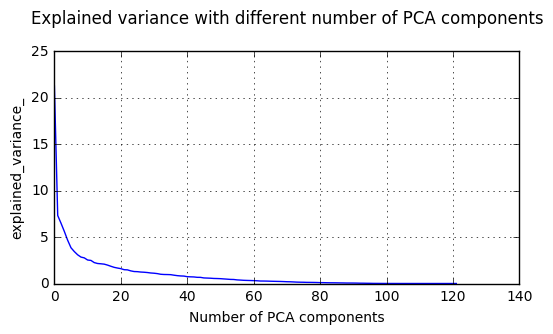

In [119]:
# PCA
# Figure out the number of components to use
pca = PCA()
pca.fit(x_train)
plt.figure(1, figsize=(6, 3))
plt.plot(pca.explained_variance_, linewidth=1)
plt.grid()
plt.xlabel('Number of PCA components')
plt.ylabel('explained_variance_')
plt.title('Explained variance with different number of PCA components\n')

#### Analysis of PCA component

By looking at the plot above, we notice that when we include around 40 pricipal componenets, we will have most of the variance explained. We will use this as the number to use in the PCA model that we train and test the data on. 

In [161]:
pca = PCA(n_components=40)
linreg_pca = LinearRegression()
pipe = Pipeline(steps=[('pca', pca), ('linear', linreg_pca)])
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print('PCA\n====================')
print 'R squared of PCA:', pipe.score(x_test, y_test)
print('')


PCA
R squared of PCA: 0.539067851007



#### Analysis of PCA

By looking at the $R^2$ above, we see that the $R^2=0.54$ is also much better than the baseline model, but d=fail to outperform LASSO.

To understand the model better, we will need a slightly different interpretation compared to RIdge/LASSO. As mentioned above, each principal component that we get from PCA is essentially a linear combination of the original food items. In our case, we can consider each principal component as a particular kind of diet(with different proportion of each type of food). The disease rate is then regressed as a linear relationship with the "diets" from principal components. If the coefficient is positive, it implies that consuming more of the particular kind of combination of food comsumption will increase the disease rate, and vise versa. In our model, we take in 40 different combined "diets" as the predictor. However, since we do not have each component exactly match a particular county's diet pattern, it is hard to further interpret the prediction model based on specific country-wise or regional diets.

We can still look at the resulting principal components from below.

In [100]:
pca_comp = pca.components_.shape

### AC 209a Required Model

Noticing that linear model, Ridge, LASSO and even PCA are all essentially linear fit on the data, with PCA being the disease rate against a combination of food(diet) and all others being disease vs food, we might want to consider some non-linear relationship between the response and predictor. 

With over 100 original predictor, it might be hard for us to guess a reasonable shape of the curve or add appropriate higher order terms without adding much high dimensionality problems. In this case, we would like to study the *Multivariate Adaptive Regression Spline(MARS)*, which essentially allow us to fit an adaptive "Hinge" curve to the data for a more flexible prediction. MARS is a non-parametric regression technique and can be seen as an extension of linear models that automatically models nonlinearities and interactions between variables.

We first apply the model on all original food predictors to check the performance. 

In [165]:
from pyearth import Earth
from matplotlib import pyplot

#Fit an Earth model
model = Earth()
model.fit(x_train, y_train)

#Print the model
print(model.summary())

#Plot the model
y_hat = model.predict(x_test)
print('Multivariate Adaptive Regression Spline\n====================')
print 'R squared of MARS:', r2(y_test, y_hat)

Earth Model
----------------------------------------
Basis Function     Pruned  Coefficient  
----------------------------------------
(Intercept)        No      33.3904      
h(x49-0.707517)    Yes     None         
h(0.707517-x49)    No      11.9776      
h(x51-1.1498)      Yes     None         
h(1.1498-x51)      No      -10.6492     
x44                No      6.2035       
h(x13+0.297474)    No      -4.76281     
h(-0.297474-x13)   No      -65.9754     
h(x3+0.104981)     No      5.27086      
h(-0.104981-x3)    Yes     None         
h(x27+0.66172)     Yes     None         
h(-0.66172-x27)    No      895.17       
h(x97+0.485113)    Yes     None         
h(-0.485113-x97)   No      -2346.9      
x81                No      -5.72141     
h(x115+0.295115)   Yes     None         
h(-0.295115-x115)  No      -60.472      
x65                Yes     None         
h(x11+0.16454)     Yes     None         
h(-0.16454-x11)    No      74.0264      
h(x89-0.138265)    Yes     None         
h(0.

By looking at the $R^2$ above, we notice that the $R^2$ from the training model is high as 0.7, but the $R^2$ on the testing set is again negative.

Attempting to understand such behavior, it might due to the issue of overfitting. When we apply non-linear fit to the training set of 122 food items, we might have overfit the data and when it turns to the testing set of year 2012, the model fit gets worse. 

### Model Selection

Based on the $R^2$ shown above for all models, we have noticed that LASSO gives the best prediction $R^2=0.556$, which out performs the other models. It makes sense that LASSO authomatically help us regularize the overwhelming terms in food consumption that are highly correlated/not related to response. This may be the reason why LASSO out-performs a simple linear regression and Ridge regression, of which they either not have regularization at all, or not allowing for the corfficient of the predictors to go to zero. 

As LASSO becomes our choice of model for predicting the disease rate from food data, we may use the $R^2$ from LASSO to tune the parameter of how many years we want to include when calculating the previous year average. Notice that in this case, since we only have disease data for year 2000 and 2012, we lack one "TRUE" test data if we tune on data from 2012. We will perform this analysis anyways now, just to illustrate the methods we want to use, but keep in mind that in practice, we should and would never use the test set to tune parameters. 



### More parameter tuning - number of years average we take


In [168]:
coeff_count = []
scores = []
for num_years in range(1,31):
    xy_diabetes_2012_all = getXY(num_years, disease=disease_data)
    xy_diabetes_2000_all = getXY(num_years, disease=disease_data, disease_year=2000)
    # Clean out whole columns that are NaN
    xy_diabetes_2012_all = xy_diabetes_2012_all.dropna(axis=1, how='all')
    xy_diabetes_2000_all = xy_diabetes_2000_all.dropna(axis=1, how='all')
    # Split into train and test
    x_train = xy_diabetes_2000_all.iloc[:,:-1]
    x_test = xy_diabetes_2012_all.iloc[:,:-1]
    # Standardize x
    x_train = preprocessing.scale(x_train)
    x_test = preprocessing.scale(x_test)
    y_train = xy_diabetes_2000_all.iloc[:,-1]
    y_test = xy_diabetes_2012_all.iloc[:,-1]
    lasso = Lasso()
    lasso.fit(x_train, y_train)
    coeff_count.append(len(lasso.coef_[lasso.coef_ != 0]))
    scores.append(lasso.score(x_test, y_test))
    

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We first look at how many predictors are left after LASSO depending on the sleeciton of number of years to use for average. We see from the plot below that the number of predictors left range around 40. 

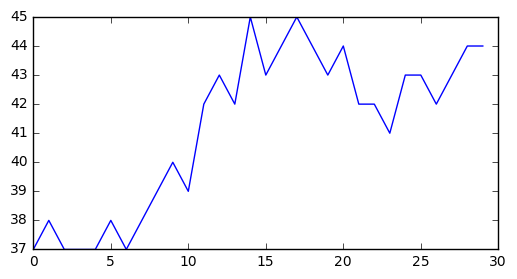

In [169]:
plt.figure(1, figsize=(6, 3))
plt.plot(coeff_count, linewidth=1)

We then check for the prediction score from LASSO if we use different number of years in calculating mean. From the plot below, we can see that the $R^2$ increase in general, as we increase the number of years to use from 2 to around 25. However,as mentioned above, we should be aware of the problem that if we use too many years in average, our predictors set will be highly correlated for year 2000 and 2012. This may also be the reason for why the $R^2$ dropped if we use more than 25 years for average. 

To achieve a relatively high $R^2$ and also try avoid using too much overlapping data in mean calculation, we would potentially use 20-25 years in calculating the food consumption average, and we can thus achieve a $R^2$ of approximately 0.57 on year 2012. 

We would like to have additional disease data on another year to actually test our choice of paramter here, but due to the lack of disease data, we cannot perform this "TRUE" test here. 

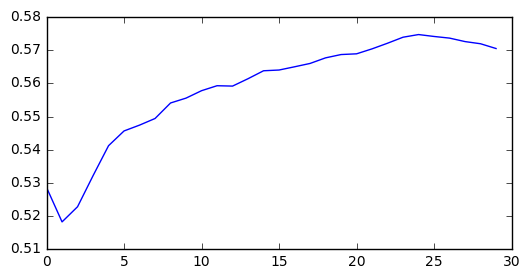

In [170]:
plt.figure(1, figsize=(6, 3))
plt.plot(scores, linewidth=1)

So after we have successfully come up with some pretty good models (LASSO!) to predict food, we now have restored our faith in food being an OK predictor for Diabetes. So the natural next question is what food do we eat?

## So what food do we eat?

### Protein/fat exploration

We would like to start off with inspecting if food nutrients have any association with Diabetes, before diving deep into the actual food items. Specifically, we would like to plot the disease rate for a particular year against the total fat/protein from crops/livestock, and see if there is any clear correlation between. This is just an exploration based a common assumption of "protein being good and fat is bad" in general:

In [148]:
def plotDiseaseNutrient(num_years_included, disease=disease_data, disease_year=2012, disease_gender="Both sexes"):
    # Grab the appropriate food metrics
    crops_ = crops[(crops["Unit"] == "g/capita/day")]
    livestock_ = livestock[(livestock["Unit"] == "g/capita/day")]

    # Years of food data needed before disease year
    years = ["Y" + str(disease_year - i) for i in range(num_years_included,-1,-1)]
    cols = ["Country", "Item", "Element"]
    cols = cols + years

    crops_ = crops_[cols]
    livestock_ = livestock_[cols]

    crops_protein = crops_[crops_['Element']=="Protein supply quantity (g/capita/day)"]
    crops_fat = crops_[crops_['Element']=="Fat supply quantity (g/capita/day)"]

    livestock_protein = livestock_[livestock_['Element']=="Protein supply quantity (g/capita/day)"]
    livestock_fat = livestock_[livestock_['Element']=="Fat supply quantity (g/capita/day)"]

    # Sum of protein consumption for each country across all years
    crops_protein_ag = crops_protein.groupby('Country').sum()
    livestock_protein_ag = livestock_protein.groupby('Country').sum()
    crops_protein_mean = np.mean(crops_protein_ag, axis=1)
    livestock_protein_mean = np.mean(livestock_protein_ag, axis=1)

    
    crops_fat_ag = crops_fat.groupby('Country').sum()
    livestock_fat_ag = livestock_fat.groupby('Country').sum()
    crops_fat_mean = np.mean(crops_fat_ag, axis=1)
    livestock_fat_mean = np.mean(livestock_fat_ag, axis=1)

    # Combine crops and livestock
    food = pd.concat([crops_protein_ag, livestock_protein_ag, crops_fat_ag, livestock_fat_ag], axis=1)

    # Only use the countries that are in both food and response
    disease_countries = disease.iloc[:,0].as_matrix().astype(str) # This has 'nan' and 'Country' but it doesn't matter
    food_countries = food.index.tolist()
    common_countries = np.asarray(list(set(disease_countries).intersection(food_countries)))

    crops_protein_mean = crops_protein_mean.loc[common_countries].sort_index()
    livestock_protein_mean = livestock_protein_mean.loc[common_countries].sort_index()
    crops_fat_mean = crops_fat_mean.loc[common_countries].sort_index()
    livestock_fat_mean = livestock_fat_mean.loc[common_countries].sort_index()
    
    y = disease[(disease.Year == disease_year) & (disease.Country.isin(common_countries))][['Country', " " + disease_gender, ]].sort_index()
    
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)
    
    ax1.scatter(crops_protein_mean,y.iloc[:,1])
    ax1.set_title("Disease Rate vs. Crops Protein")
    ax2.scatter(livestock_protein_mean, y.iloc[:,1])
    ax2.set_title("Disease Rate vs. Livestock Protein")
    ax3.scatter(crops_fat_mean,y.iloc[:,1])
    ax3.set_title("Disease Rate vs. Crops Fat")
    ax4.scatter(livestock_fat_mean, y.iloc[:,1])
    ax4.set_title("Disease Rate vs. Livestock Fat")

#### Plot the disease rate against protein/fat for year 2000:

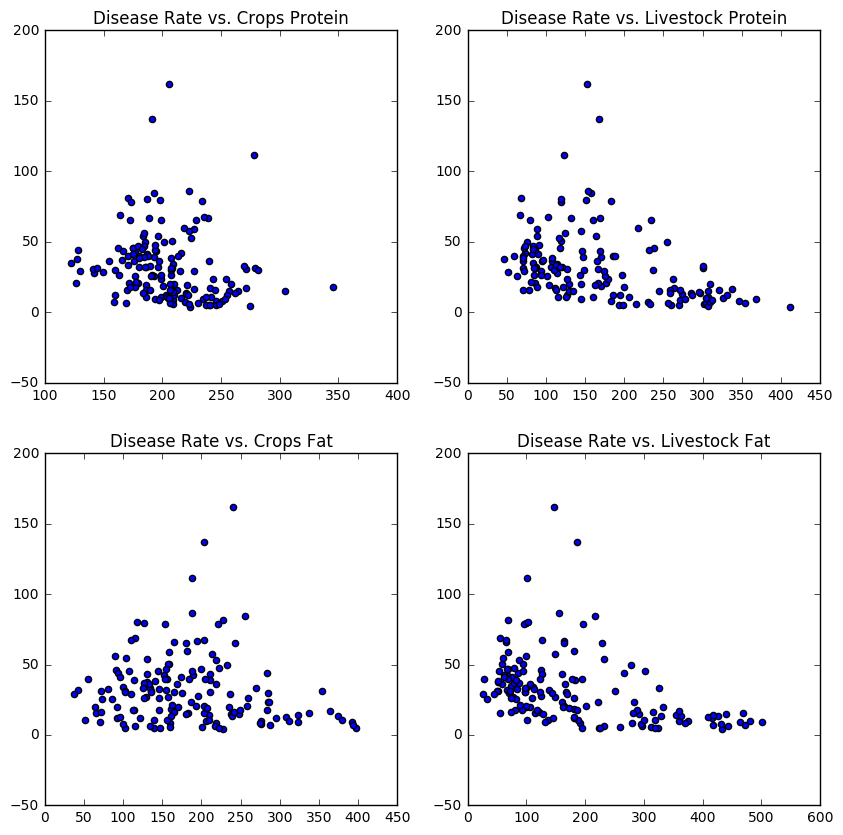

In [149]:
plotDiseaseNutrient(num_years_included=20, disease=disease_data, disease_year=2000, disease_gender="Both sexes")

#### Plot the disease rate against protein/fat for year 2012:

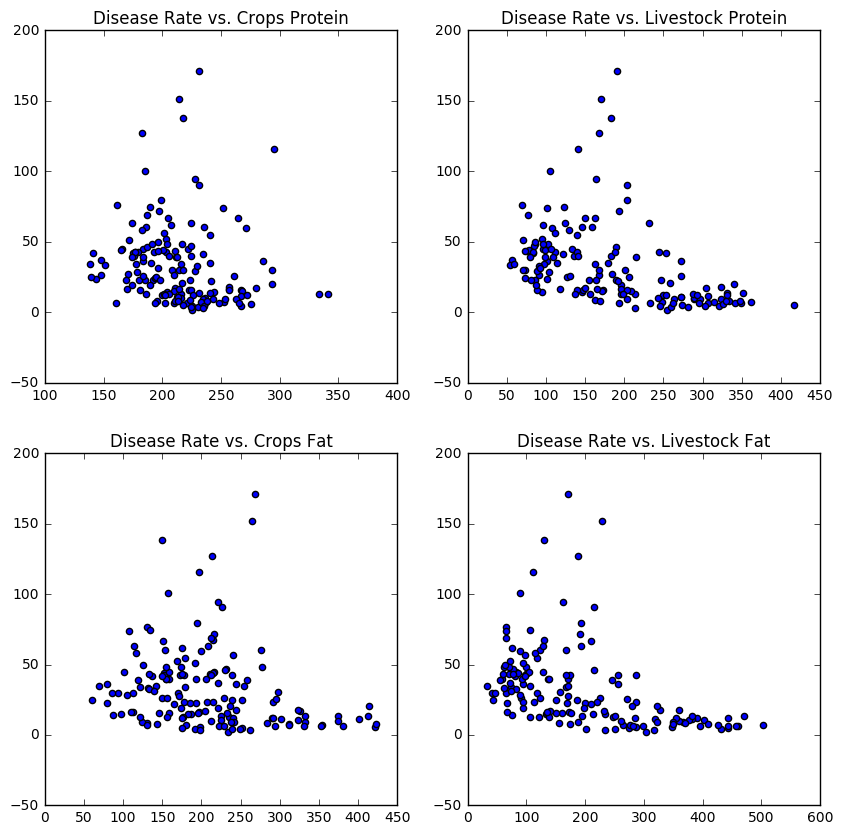

In [150]:
plotDiseaseNutrient(num_years_included=20, disease=disease_data, disease_year=2012, disease_gender="Both sexes")

From all the scatter plots above, **we fail to see a significant association between protein/fat and Diabetes rates.** Hence, we do not bother fitting any model to this data and proceed to inspect individual food item's effects instead.

### Which food items do we eat then?

To extract the food items to eat and the ones to avoid we look at the coefficients produced by our best model above -  Lasso regression.

Food with the most positive coefficients are termed as the **most unhealthy** as they are positively correlated with Diaebetes, while food with the most negative coefficients are described as the **most healthy** as they are negatively correlated with Diabetes.

Here are the top 8 most healthy food chosen from Lasso:
- Potatoes
- Eggs
- Milk
- Tomatoes
- Sugar Crops
- Apples and products
- Honey
- Freshwater Fish

Here are top 8 least healthy food chosen from Lasso:
- Peas
- Soybean Oil
- Oilcrops
- Spices
- Barley
- Maize
- Sugar
- Fermented Beverages

These above make sense. An interesting one is Sugar crops appearing in 'healthy' instead of 'unhealthy'. With some googling we realize sugar crops refer to the vegetable - the sugar plant, rather than refined sugar. That makes more sense. The rest on the list make sense, and are actually even food recommended by doctors to Diabetic patients. The food to avoid for Diabetes also make quite a lot of sense. Most of them are high in Carbohydrates and/or sugar, which is proven to be positively associated with Diabetes risk.

When we plot the individual linear association of the above food with Diabetes rates, we realize that some of them do not have an equally negative or positive relationship with Diabetes rates. For example, although Sugar is the the top 8 least healthy food classified by Lasso, it actually has a slightly negative correlation with Diabetes rate! This is likely because most countries in the world use a lot of sugar, so if we just plot the linear association of JUST sugar with Diabetes rate, we are not controlling for all the other food items. Hence, picking the most and least healthy food from Lasso still makes a lot more sense than just picking from a sorted list of correlation of food item to Diabetes rates.

However for illustration purposes we still pick some of the most and least unhealthy food items from Lasso's output and plot them:

In [53]:
# Combine livestock and crops
food_df = pd.concat([livestock, crops])

Specifically, we use a scatter plot to plot the food's supply of a certain year against the Diabetes rate of that year. We then fit a line to the scatter plot for better visualization.

In [55]:
# Takes in combined food data frame and disease year
def scatterFoodAndDiabetes(food, year, ax, color):
    disease_y = diabetes_data.loc[diabetes_data['Year']==year][['Country', ' Both sexes']]
    food_x = food_df.loc[(food_df['Item'] == food) & (food_df['Unit'] == 'g/capita/day') & (food_df['Element'] == 'Food supply quantity (g/capita/day)')][['Country', 'Y%d' % year]]

    # Find common countries in both dfs
    d_countries = disease_y.iloc[:,0].tolist()
    f_countries = food_x.iloc[:,0].tolist()
    common_countries = set(d_countries).intersection(f_countries)

    # Plot only these common countries
    disease_y = disease_y.loc[disease_y['Country'].isin(common_countries)]
    food_x = food_x.loc[food_x['Country'].isin(common_countries)]
    # Sort based on country, then extract lists so I can plot
    disease_y = disease_y.sort_values('Country', ascending=True).iloc[:,1].tolist()
    food_x = food_x.sort_values('Country', ascending=True).iloc[:,1].tolist()
    # Remove NaN values if we still see them here: Should not happen, but just in case
    disease_y_ = []
    food_x_ = []
    for i in range(0, len(disease_y)):
        d = disease_y[i]
        f = food_x[i]
        if not np.isnan(d) and not np.isnan(f):
            disease_y_.append(d)
            food_x_.append(f)
    disease_y = disease_y_
    food_x = food_x_

    ax.set_xlabel('g/capita/day of food', fontsize=15)
    ax.set_ylabel('Diabetes deaths per 100,000', fontsize=15)
    ax.set_ylim(0,1.05*max(disease_y))
    ax.set_xlim(0, 1.05*max(food_x))
    ax.set_title("%s\n" % (food), fontsize=20)
    ax.scatter(food_x, disease_y, color='black', marker='+', s=10, alpha=0.5)
    ax.plot(np.unique(food_x), np.poly1d(np.polyfit(food_x, disease_y, 1))(np.unique(food_x)), color=color)
    ax.grid()

    print 'Correlation of %s and disease: ' % food, np.corrcoef(disease_y, food_x)[0][1]

Correlation of Pigmeat and disease:  -0.456729718816
Correlation of Honey and disease:  -0.326866394145
Correlation of Apples and products and disease:  -0.381821393741


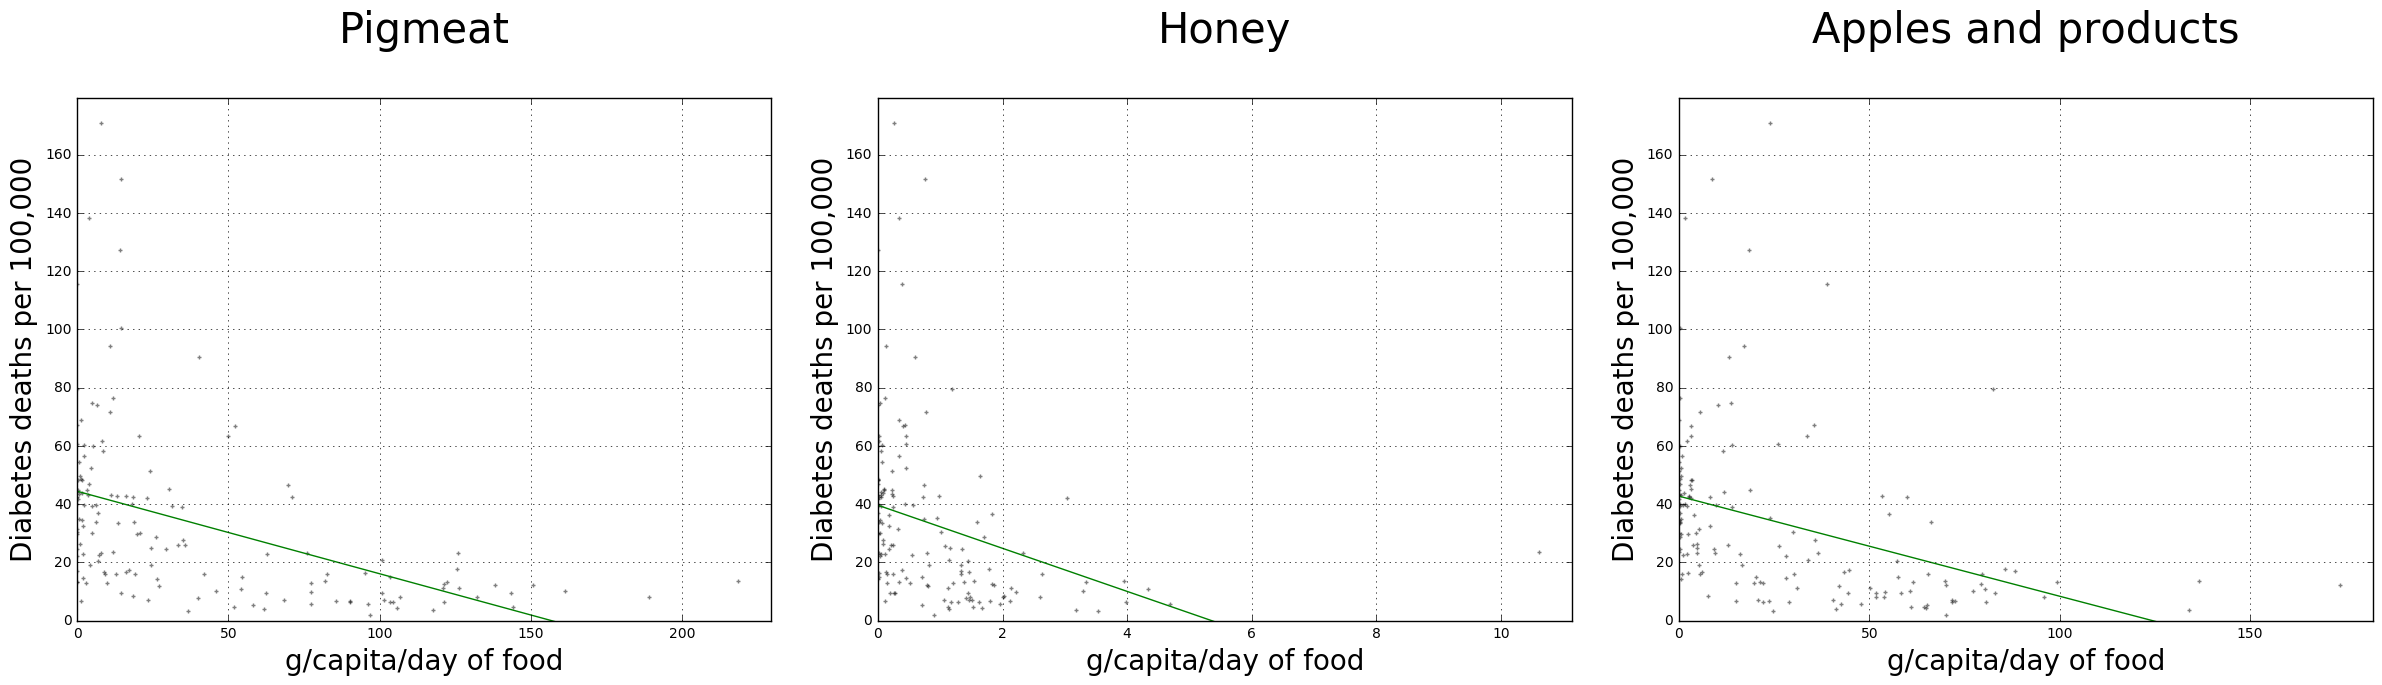

In [74]:
# Plot the most healthy foods
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
healthiest_foods = ['Pigmeat', 'Honey', 'Apples and products']
year = 2012
i = 0
for food in healthiest_foods:
    scatterFoodAndDiabetes(food, year, fig.axes[i], 'green')
    i += 1
plt.tight_layout(pad=5, w_pad=3, h_pad=10)

As we can see these food have an inverse relationship with Diabetes. Hence, we have to eat more of these food! We are not able to establish a causal relationship between these food and diabetes as we did not perform an experiment where there is random assignment to control and treatment groups, but there is still sufficient evidence of association.

Correlation of Peas and disease:  0.293669740322
Correlation of Oilcrops and disease:  0.395122319271
Correlation of Spices, Other and disease:  0.271492712599


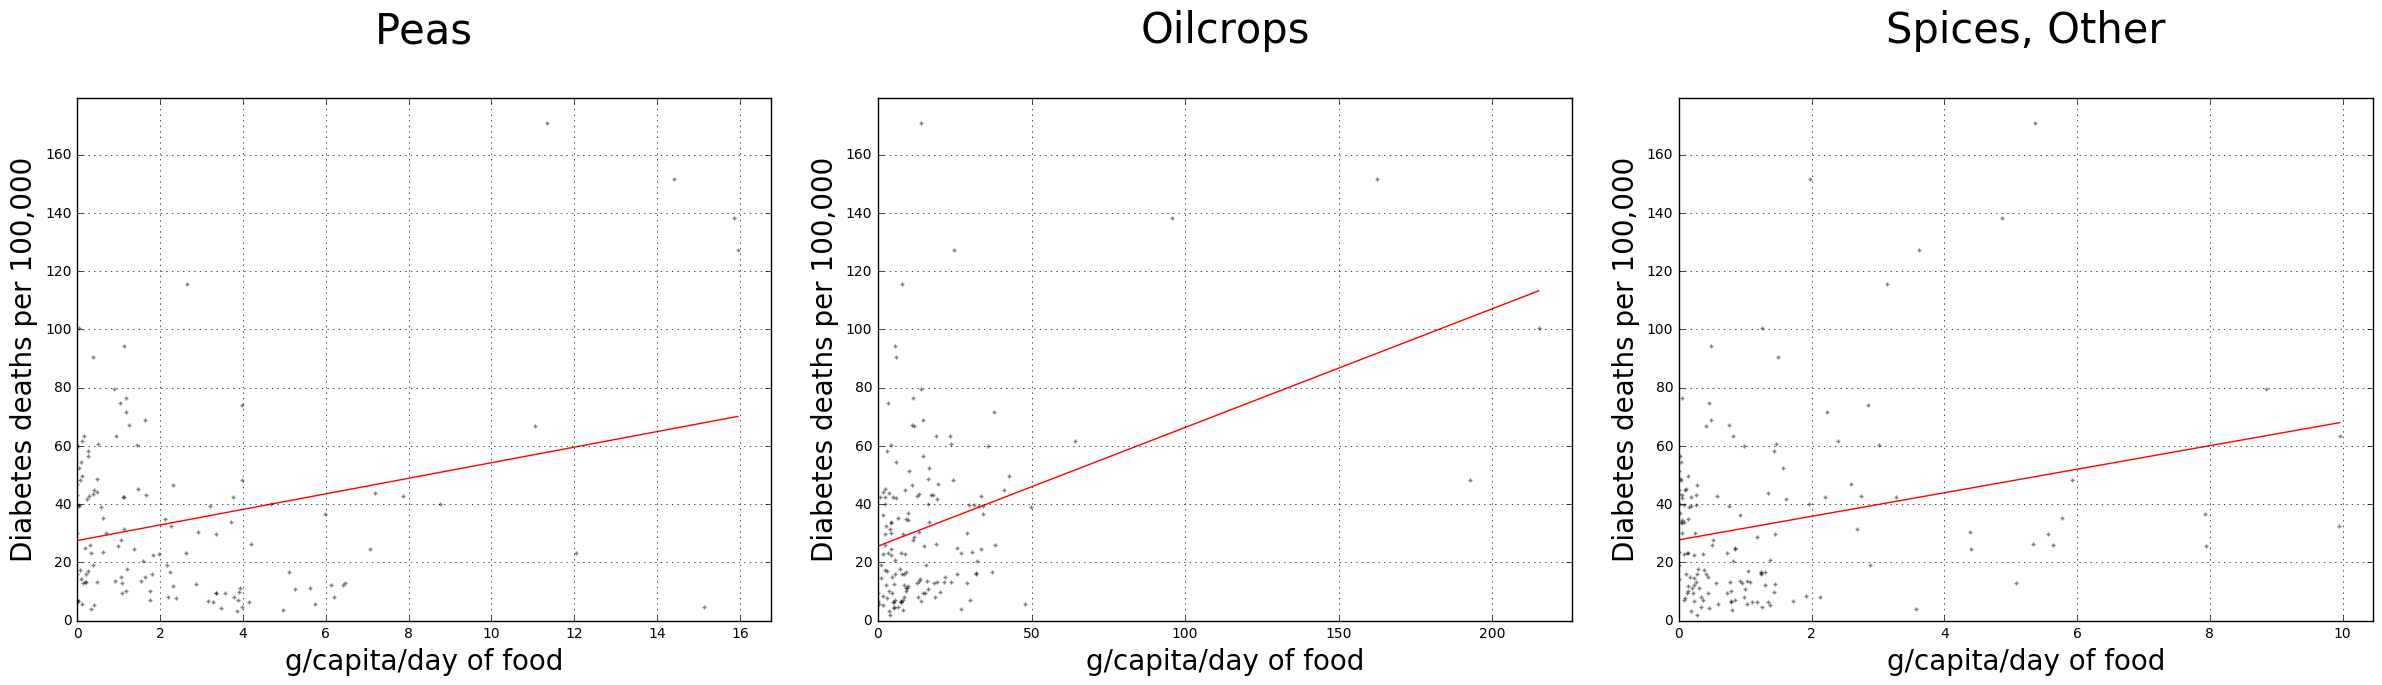

In [77]:
# Plot the most unhealthy foods
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
healthiest_foods = ['Peas', 'Oilcrops', 'Spices, Other']
year = 2012
i = 0
for food in healthiest_foods:
    scatterFoodAndDiabetes(food, year, fig.axes[i], 'red')
    i += 1
plt.tight_layout(pad=5, w_pad=3, h_pad=10)

These are the food to avoid! They have a high correlation with Diabetes risk, and is also part of the top 8 most unhealthy food predicted by our Lasso model.

## Conclusion

To summarize everything that we have discussed so far, we have come up with quite a few models for food item to predict Diabetes risk. Some of them such as Lasso, Ridge and PCA are pretty succesful, which shines hope on using food data to forecast Diabetes rates in the future. As we use food and Diabetes data in 2000 to predict Diabetes rate in 2012 given food data in 2012 with good accuracy, we might be able to extrapolate this model to predict for future years. This is likely possible also because of the random sampling methods that surveyors used to collect the data. 

Here are some of our key findings:
- The diet of low Diabetes risk countries and high Diabetes risk countries are largely similar
- It IS POSSIBLE to predict Diabetes risk with food item data with a good degree of accuracy
- Protein and fat do not have much association with Diabetes risk
- Most of the most and least healthy food we found correspond with conventional wisdom to decrease and increase Diabetes risk respectively

That's the end of our report. Thank you for a great project, and a great semester. Thank you Steve for your advice and being a good mentor!